# DGD Training Demo: Using the DGDTrainer Class

This notebook demonstrates the complete usage of the DGDTrainer class from `src/training/trainer.py`. We'll train a Deep Generative Decoder (DGD) model on the FashionMNIST dataset using the standard production configuration, showcasing:

- Configuration setup using Hydra/OmegaConf with the standard config
- Dataset preparation and data loading
- ClearML integration for experiment tracking
- Model training with representation layers and GMM fitting
- Visualization of training progress and results
- Model evaluation and sample generation
- Model saving and loading

The DGD model combines:
- **Representation Layer**: Learnable per-sample embeddings in latent space
- **Convolutional Decoder**: Neural network that maps latent codes to images
- **Gaussian Mixture Model**: Probabilistic model fitted to the learned representations

**Note**: This demo uses the standard production configuration for full model capacity. If you have limited GPU memory, you can uncomment the memory optimization lines in the configuration section.

## 1. Setup Environment and Imports

First, let's import all necessary libraries and set up the environment.

In [ ]:
# Standard library imports
import os
import sys
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data science and ML libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

# Configuration management
from omegaconf import DictConfig, OmegaConf
import hydra
from hydra import initialize, compose

# Experiment tracking
from clearml import Task

# Add project root to path for imports
current_dir = Path.cwd()
if 'notebooks' in current_dir.parts:
    # We're in the notebooks folder, go up one level
    project_root = current_dir.parent
else:
    project_root = current_dir

sys.path.append(str(project_root))
sys.path.append(str(project_root / 'src'))

from tgmm import GaussianMixture

# Import our custom modules
from src.training.trainer import DGDTrainer
from src.data.dataloader import create_dataloaders, get_sample_batches
from src.models import RepresentationLayer, DGD, ConvDecoder
from src.visualization import plot_training_losses, plot_images

# Set device and apply memory optimizations
if torch.cuda.is_available():
    # Clear GPU cache for all devices
    torch.cuda.empty_cache()
    
    # Get number of CUDA devices
    num_devices = torch.cuda.device_count()
    print(f"Number of CUDA devices: {num_devices}")
    
    # If multiple devices, select the one with most available memory
    if num_devices > 1:
        max_memory = 0
        best_device = 0
        
        print("\nScanning devices for available memory:")
        for i in range(num_devices):
            total_memory = torch.cuda.get_device_properties(i).total_memory
            allocated_memory = torch.cuda.memory_allocated(i)
            reserved_memory = torch.cuda.memory_reserved(i)
            available_memory = total_memory - reserved_memory
            
            print(f"Device {i}: {torch.cuda.get_device_name(i)}")
            print(f"  Total Memory: {total_memory/1024**2:.2f} MB")
            print(f"  Allocated: {allocated_memory/1024**2:.2f} MB")
            print(f"  Reserved: {reserved_memory/1024**2:.2f} MB")
            print(f"  Available: {available_memory/1024**2:.2f} MB")
            
            if available_memory > max_memory:
                max_memory = available_memory
                best_device = i
        
        device = torch.device(f'cuda:{best_device}')
        torch.cuda.set_device(device)
        print(f"\n- Selected device {best_device} with {max_memory/1024**2:.2f} MB available memory")
    else:
        device = torch.device('cuda:0')
        print(f"Device 0: {torch.cuda.get_device_name(0)}")
        print(f"  Total Memory: {torch.cuda.get_device_properties(0).total_memory/1024**2:.2f} MB")
    
    # Set memory management optimizations
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Enable memory-efficient attention if available
    try:
        torch.backends.cuda.enable_flash_sdp(False)  # Disable for compatibility
    except:
        pass
    
    print(f"\n- Using device: {device}")
    print(f"- GPU: {torch.cuda.get_device_name(device)}")
    print(f"- GPU Memory: {torch.cuda.get_device_properties(device).total_memory / 1e9:.1f} GB")
    print(f"- Applied CUDA memory optimizations")
else:
    device = torch.device('cpu')
    print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)


try:
    from cuml.accel import install
    install()
except ImportError:
    print("Cuml not installed, using CPU for umap and sklearn")


print("- All imports successful!")
print(f"- Project root: {project_root}")
print(f"- PyTorch version: {torch.__version__}")
print(f"- CUDA available: {torch.cuda.is_available()}")
print("- Memory optimizations applied for local training")

✓ Using tgmm package for Gaussian Mixture Model
✓ Using cuML (GPU-accelerated) for dimensionality reduction
Number of CUDA devices: 1
Device 0: NVIDIA GeForce RTX 4060 Laptop GPU
  Total Memory: 7805.56 MB

- Using device: cuda:0
- GPU: NVIDIA GeForce RTX 4060 Laptop GPU
- GPU Memory: 8.2 GB
- Applied CUDA memory optimizations
cuML: Installed accelerator for sklearn.
✓ Using cuML (GPU-accelerated) for dimensionality reduction
Number of CUDA devices: 1
Device 0: NVIDIA GeForce RTX 4060 Laptop GPU
  Total Memory: 7805.56 MB

- Using device: cuda:0
- GPU: NVIDIA GeForce RTX 4060 Laptop GPU
- GPU Memory: 8.2 GB
- Applied CUDA memory optimizations
cuML: Installed accelerator for sklearn.
cuML: Installed accelerator for umap.
cuML: Successfully initialized accelerator.
- All imports successful!
- Project root: /home/asp/Downloads/HeaDS/ImageDGD
- PyTorch version: 2.7.0+cu126
- CUDA available: True
- Memory optimizations applied for local training
cuML: Installed accelerator for umap.
cuML: S

## 2. Load Configuration

Load the training configuration using Hydra/OmegaConf. We'll use the standard production configuration which provides full model capacity and training settings. You can optionally apply memory optimizations if running on limited hardware.

In [2]:
config_dir = project_root / "config"
relative_config_path = "../config"

with initialize(version_base=None, config_path=relative_config_path):
    config = compose(config_name="config")

print("CONFIGURATION")
print(f"{'='*60}")
print(OmegaConf.to_yaml(config))
print(f"{'='*60}")

CONFIGURATION
random_seed: 42
experiment_name: ImageDGD_Default
description: Default ImageDGD training configuration
data:
  dataset: FashionMNIST
  data_dir: ./data
  batch_size: 128
  num_workers: 4
  pin_memory: true
  use_subset: false
  subset_fraction: 1.0
  normalize: true
model:
  representation:
    n_features: 2
    distribution: uniform_ball
    dist_params:
      radius: 1.0
  decoder:
    hidden_dims:
    - 128
    - 64
    - 32
    output_channels: 1
    output_size:
    - 28
    - 28
    init_size:
    - 4
    - 4
    kernel_size: 3
    stride: 2
    padding: 1
    output_padding: 1
    bias: true
    normalization: batch
    activation: leaky_relu
    final_activation: sigmoid
    dropout_rate: 0.0
    upsampling_mode: transpose
    use_spectral_norm: false
    use_self_attention: false
    attention_resolution: 32
  gmm:
    n_components: 20
    covariance_type: full
    init_params: kmeans
    verbose: false
    max_iter: 1000
    tol: 0.001
    n_init: 1
    warm_sta

## 3. Prepare Dataset and Data Loaders

Load and prepare the FashionMNIST dataset with proper transformations and create data loaders.

Data directory: /home/asp/Downloads/HeaDS/ImageDGD/data
- Configuration updated for FashionMNIST dataset
- Added missing dataloader fields (dataset_name, root_dir, shuffle settings)
- Added transforms configuration
Loading dataset and creating data loaders...
Train dataset: 60000 (total: 60000)
Test dataset: 10000 (total: 10000)
Image shape: torch.Size([1, 28, 28])
Image size: 784
- Train loader: 469 batches
- Test loader: 79 batches
- Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
- Prepared sample data for visualization
- Prepared sample data for visualization


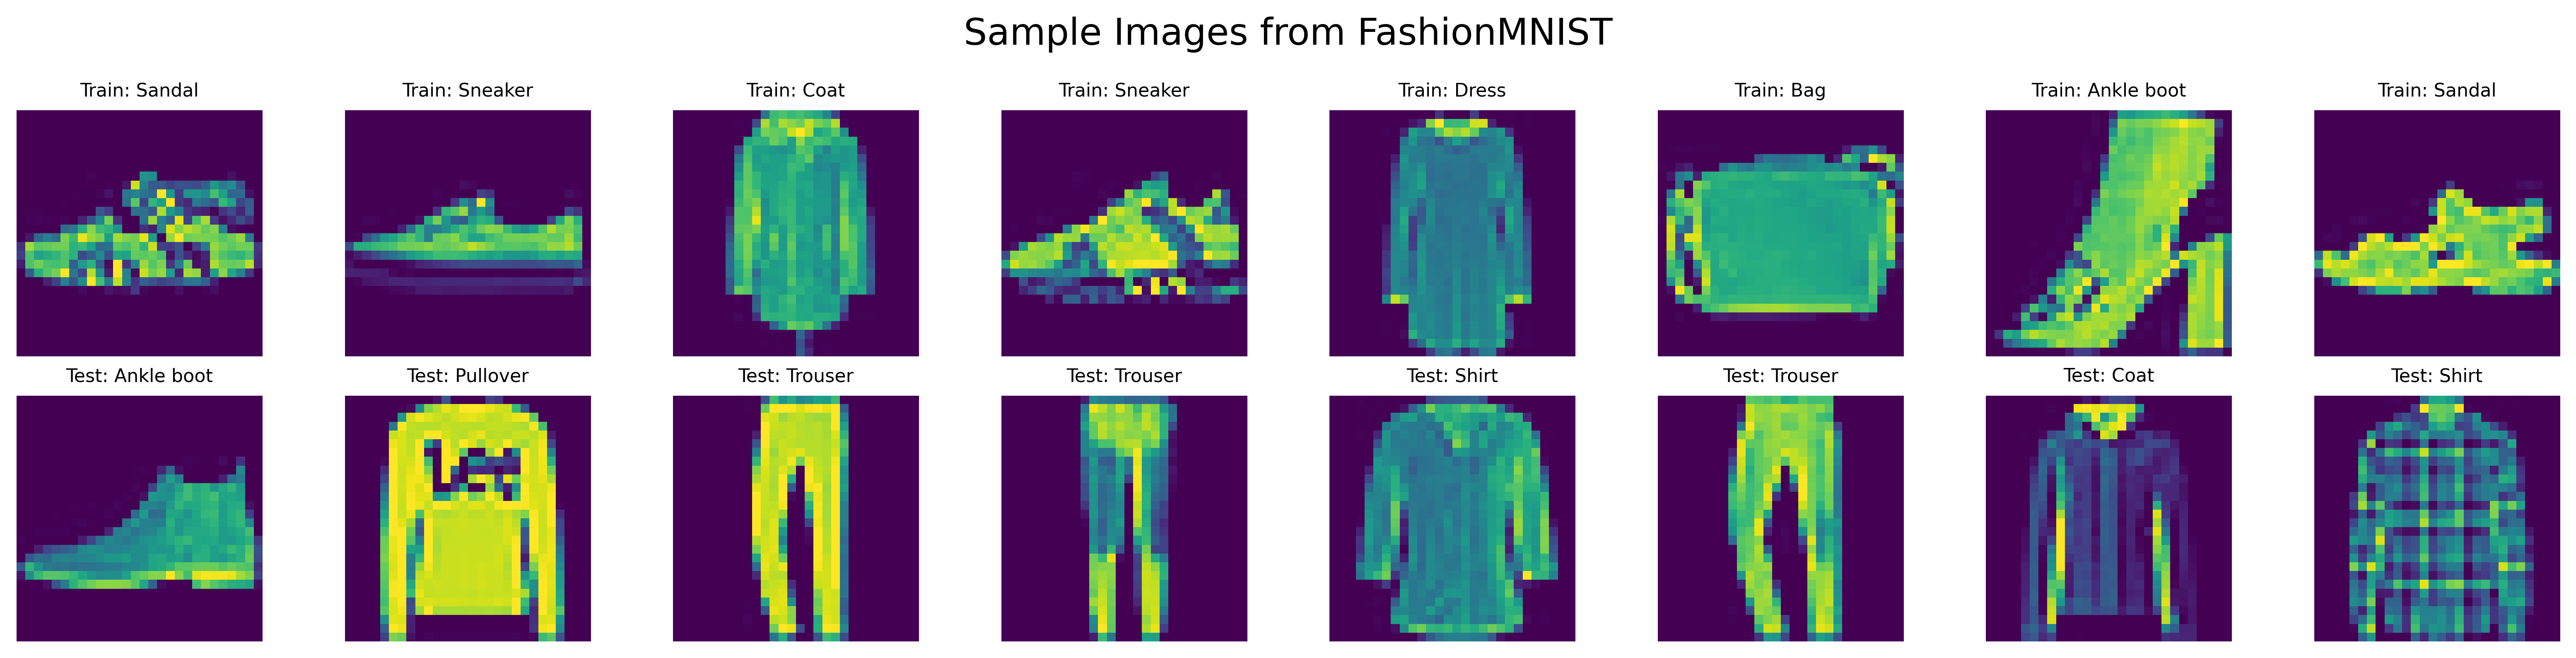


📊 Dataset Summary:
  Input shape: torch.Size([1, 28, 28])
  Number of classes: 10
  Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  Sample batch sizes: train=128, test=128
  Value range: [-1.00, 1.00] (normalized to [-1,1])


In [3]:
# Create data directories
data_dir = project_root / "data"
data_dir.mkdir(exist_ok=True)

print(f"Data directory: {data_dir}")

# OmegaConf is in struct mode, so we need to disable it to add new fields
OmegaConf.set_struct(config, False)  # Disable struct mode temporarily

# Update the config to work with the dataloader function - add missing fields
config.data.dataset_name = config.data.dataset  # dataloader expects 'dataset_name'
config.data.root_dir = str(data_dir)  # dataloader expects 'root_dir'
config.data.download = True
config.data.shuffle_train = True  # Add shuffle settings
config.data.shuffle_test = False

# Add transforms configuration if not present
if 'transforms' not in config.data:
    config.data.transforms = {
        'train': ['ToTensor', 'Normalize'],
        'test': ['ToTensor', 'Normalize']
    }

# Define class names for FashionMNIST
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Update the class names in config
config.data.class_names = class_names

# Re-enable struct mode if desired
OmegaConf.set_struct(config, True)

print("- Configuration updated for FashionMNIST dataset")
print("- Added missing dataloader fields (dataset_name, root_dir, shuffle settings)")
print("- Added transforms configuration")

# Create data loaders using our custom dataloader function
print("Loading dataset and creating data loaders...")
train_loader, test_loader, loaded_class_names = create_dataloaders(config)

print(f"- Train loader: {len(train_loader)} batches")
print(f"- Test loader: {len(test_loader)} batches")
print(f"- Classes: {loaded_class_names}")

# Prepare sample data for visualization using the new function
sample_data = get_sample_batches(train_loader, test_loader, device)
print(f"- Prepared sample data for visualization")

# Note: sample_data contains a full batch, we'll only visualize the first 8 samples
# Unpack the sample data
indices_train, images_train, labels_train, indices_test, images_test, labels_test = sample_data

# Visualize some samples
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('Sample Images from FashionMNIST', fontsize=16)

n_viz = min(8, len(images_train))  # Visualize up to 8 samples
for i in range(n_viz):
    # Train samples
    img = images_train[i].cpu().squeeze()
    label = labels_train[i].cpu().item()
    axes[0, i].imshow(img, cmap='viridis')
    axes[0, i].set_title(f'Train: {class_names[label]}', fontsize=8)
    axes[0, i].axis('off')
    
    # Test samples  
    img = images_test[i].cpu().squeeze()
    label = labels_test[i].cpu().item()
    axes[1, i].imshow(img, cmap='viridis')
    axes[1, i].set_title(f'Test: {class_names[label]}', fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Dataset Summary:")
print(f"  Input shape: {images_train[0].shape}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Classes: {class_names}")
print(f"  Sample batch sizes: train={len(images_train)}, test={len(images_test)}")
print(f"  Value range: [{images_train.min():.2f}, {images_train.max():.2f}] (normalized to [-1,1])")

## 4. Initialize ClearML Task

Set up ClearML for experiment tracking. This will log all training metrics, configurations, and artifacts.

In [ ]:
# Initialize ClearML task for experiment tracking
print("Initializing ClearML task...")

try:
    # Create a task for this training session
    task = Task.init(
        project_name="ImageDGD", 
        task_name=f"DGD Training Demo - {config.model.representation.distribution}",
        tags=["demo", "notebook", config.data.dataset, f"{config.training.epochs}epochs"]
    )
    
    # Connect the configuration to ClearML
    task.connect(config)
    
    # Set task description
    task.set_comment("""
    DGD Training Demo using DGDTrainer class.
    
    This experiment demonstrates:
    - Deep Generative Decoder training
    - Representation layer learning
    - GMM fitting in latent space
    - Training visualization and monitoring
    """)
    
    print("- ClearML task initialized successfully!")
    print(f"- Project: ImageDGD")
    print(f"- Task: DGD Training Demo - {config.model.representation.distribution}")
    print(f"- Task ID: {task.id}")
    
    # Get dataset sizes from the data loaders
    train_dataset_size = len(train_loader.dataset)
    test_dataset_size = len(test_loader.dataset)
    
    # Log some initial parameters
    task.set_parameters({
        "dataset_size_train": train_dataset_size,
        "dataset_size_test": test_dataset_size,
        "device": str(device),
        "pytorch_version": torch.__version__,
        "subset_used": config.data.use_subset,
        "subset_fraction": config.data.subset_fraction if config.data.use_subset else None
    })
    
except Exception as e:
    print(f"⚠️ ClearML initialization failed: {e}")
    print("⚠️ Continuing without ClearML tracking...")
    task = None

print("\\n📝 Experiment Configuration:")
print(f"  Project: ImageDGD")
print(f"  Task: DGD Training Demo")
print(f"  Dataset: {config.data.dataset}")
print(f"  Model: DGD (Deep Generative Decoder)")  # Fixed: removed non-existent config.model.type
print(f"  Distribution: {config.model.representation.distribution}")
print(f"  Device: {device}")
print(f"  Tracking: {'ClearML' if task else 'Local only'}")

Initializing ClearML task...
ClearML Task: created new task id=b21dbf8335b846299a899c986575b06d
2025-10-15 16:52:39,978 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Task: created new task id=b21dbf8335b846299a899c986575b06d
2025-10-15 16:52:39,978 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/8de4d7e9e1b94bb1b2bafe93c09b2c0b/experiments/b21dbf8335b846299a899c986575b06d/output/log
ClearML results page: https://app.clear.ml/projects/8de4d7e9e1b94bb1b2bafe93c09b2c0b/experiments/b21dbf8335b846299a899c986575b06d/output/log
- ClearML task initialized successfully!
- Project: ImageDGD
- Task: DGD Training Demo - uniform_ball
- Task ID: b21dbf8335b846299a899c986575b06d
- ClearML task initialized successfully!
- Project: ImageDGD
- Task: DGD Training Demo - uniform_ball
- Task ID: b21dbf8335b846299a899c986575b06d
\n📝 Experiment Configuration:
  Project: ImageDGD
  Task: DGD Trainin

2025-10-15 16:53:25,120 - clearml.storage - INFO - Uploading: 8.39MB from /tmp/tmpyrydwueq.png


█████████████████████████████████ 100% | 8.39/8.39 MB [00:01<00:00,  5.00MB/s]: 



2025-10-15 16:53:33,213 - clearml.storage - INFO - Uploading: 5.33MB from /tmp/tmp4bpxk8p9.png


█████████████████████████████████ 100% | 5.33/5.33 MB [00:00<00:00,  8.12MB/s]: 



2025-10-15 16:53:38,432 - clearml.storage - INFO - Uploading: 6.53MB from /tmp/tmp7x5c2klk.png


█████████████████████████████████ 100% | 6.53/6.53 MB [00:00<00:00,  7.56MB/s]: 



2025-10-15 17:02:39,943 - clearml.storage - INFO - Uploading: 6.48MB from /tmp/tmprwqgysma.png


█████████████████████████████████ 100% | 6.48/6.48 MB [00:00<00:00,  7.58MB/s]: 



2025-10-15 17:03:05,762 - clearml.storage - INFO - Uploading: 5.69MB from /tmp/tmp3v_y8e67.png


█████████████████████████████████ 100% | 5.69/5.69 MB [00:00<00:00,  9.95MB/s]: 



2025-10-15 17:14:12,078 - clearml.storage - INFO - Uploading: 5.70MB from /tmp/tmpg67kl6ui.png


██████████████████████████████████ 100% | 5.70/5.7 MB [00:00<00:00,  9.64MB/s]: 



2025-10-15 17:14:25,639 - clearml.storage - INFO - Uploading: 5.90MB from /tmp/tmp6yqv8uxe.png


██████████████████████████████████ 100% | 5.90/5.9 MB [00:02<00:00,  2.91MB/s]: 



2025-10-15 17:26:27,465 - clearml.storage - INFO - Uploading: 5.40MB from /tmp/tmpfs8xwqm3.png


██████████████████████████████████ 100% | 5.40/5.4 MB [00:00<00:00, 18.21MB/s]: 



2025-10-15 17:26:50,519 - clearml.storage - INFO - Uploading: 5.76MB from /tmp/tmp79awqb6p.png


█████████████████████████████████ 100% | 5.76/5.76 MB [00:00<00:00, 15.03MB/s]: 



2025-10-15 17:38:33,694 - clearml.storage - INFO - Uploading: 5.11MB from /tmp/tmpyc6xmdl6.png


█████████████████████████████████ 100% | 5.11/5.11 MB [00:00<00:00, 17.15MB/s]: 



2025-10-15 17:38:59,067 - clearml.storage - INFO - Uploading: 5.80MB from /tmp/tmpzesbz5m9.png


██████████████████████████████████ 100% | 5.80/5.8 MB [00:00<00:00, 18.10MB/s]: 



## Run Training Process

Now let's start the training! The trainer will handle everything including model creation, optimization, GMM fitting, and visualization.

Starting DGD training...
Decoder parameters: 242,945 (0.24M)
Train representation parameters: 120,000 (0.12M)
Test representation parameters: 20,000 (0.02M)
Total trainable parameters: 382,945 (0.38M)
Training for 200 epochs
Using device: cuda:0
Batch size: 128
Training for 200 epochs
Using device: cuda:0
Batch size: 128


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200 [TPE: 0:00:10, RT: 0:35:41]; Train Loss: 535.4936 (0.00%), Test Loss: 529.2604 (0.00%)
  Reconstruction - Train: 535.4936, Test: 529.2604


Failed to sample from GMM: Call fit() before sample().
Failed to sample from GMM: Call fit() before sample().
Failed to sample from GMM: Call fit() before sample().
Failed to sample from GMM: Call fit() before sample().
Failed to sample from GMM: Call fit() before sample().


Unused keyword parameter: max_iter during cuML estimator initialization
# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


Failed to sample from GMM: Call fit() before sample().


build_algo set to brute_force_knn because random_state is given


Training:   1%|          | 2/200 [00:51<1:15:51, 22.99s/it]

Epoch 2/200 [TPE: 0:00:10, RT: 0:34:59]; Train Loss: 531.6099 (0.73%), Test Loss: 529.2148 (0.01%)
  Reconstruction - Train: 531.6099, Test: 529.2148


Training:   2%|▏         | 3/200 [01:02<57:04, 17.39s/it]  

Epoch 3/200 [TPE: 0:00:10, RT: 0:34:55]; Train Loss: 531.5653 (0.01%), Test Loss: 529.1688 (0.01%)
  Reconstruction - Train: 531.5653, Test: 529.1688


Training:   2%|▏         | 4/200 [01:12<47:55, 14.67s/it]

Epoch 4/200 [TPE: 0:00:10, RT: 0:34:37]; Train Loss: 531.5224 (0.01%), Test Loss: 529.1245 (0.01%)
  Reconstruction - Train: 531.5224, Test: 529.1245


Training:   2%|▎         | 5/200 [01:23<42:55, 13.21s/it]

Epoch 5/200 [TPE: 0:00:10, RT: 0:34:27]; Train Loss: 531.3967 (0.02%), Test Loss: 529.0258 (0.02%)
  Reconstruction - Train: 531.3967, Test: 529.0258


Training:   3%|▎         | 6/200 [01:33<39:41, 12.28s/it]

Epoch 6/200 [TPE: 0:00:10, RT: 0:34:12]; Train Loss: 531.2502 (0.03%), Test Loss: 528.8873 (0.03%)
  Reconstruction - Train: 531.2502, Test: 528.8873


Training:   4%|▎         | 7/200 [01:43<37:25, 11.64s/it]

Epoch 7/200 [TPE: 0:00:10, RT: 0:33:54]; Train Loss: 531.0487 (0.04%), Test Loss: 528.6795 (0.04%)
  Reconstruction - Train: 531.0487, Test: 528.6795


Training:   4%|▍         | 8/200 [01:54<35:55, 11.22s/it]

Epoch 8/200 [TPE: 0:00:10, RT: 0:33:39]; Train Loss: 530.7395 (0.06%), Test Loss: 528.4480 (0.04%)
  Reconstruction - Train: 530.7395, Test: 528.4480


Training:   4%|▍         | 9/200 [02:04<34:53, 10.96s/it]

Epoch 9/200 [TPE: 0:00:10, RT: 0:33:25]; Train Loss: 530.3957 (0.06%), Test Loss: 528.0824 (0.07%)
  Reconstruction - Train: 530.3957, Test: 528.0824


Training:   5%|▌         | 10/200 [02:15<34:43, 10.96s/it]

Epoch 10/200 [TPE: 0:00:10, RT: 0:33:21]; Train Loss: 530.0190 (0.07%), Test Loss: 527.7827 (0.06%)
  Reconstruction - Train: 530.0190, Test: 527.7827


Training:   6%|▌         | 11/200 [02:26<33:57, 10.78s/it]

Epoch 11/200 [TPE: 0:00:10, RT: 0:33:08]; Train Loss: 529.5461 (0.09%), Test Loss: 527.2152 (0.11%)
  Reconstruction - Train: 529.5461, Test: 527.2152


Training:   6%|▌         | 12/200 [02:36<33:30, 10.69s/it]

Epoch 12/200 [TPE: 0:00:10, RT: 0:32:57]; Train Loss: 528.9906 (0.10%), Test Loss: 526.6441 (0.11%)
  Reconstruction - Train: 528.9906, Test: 526.6441


Training:   6%|▋         | 13/200 [02:46<33:00, 10.59s/it]

Epoch 13/200 [TPE: 0:00:10, RT: 0:32:44]; Train Loss: 528.3649 (0.12%), Test Loss: 525.8573 (0.15%)
  Reconstruction - Train: 528.3649, Test: 525.8573


Training:   7%|▋         | 14/200 [02:57<32:39, 10.53s/it]

Epoch 14/200 [TPE: 0:00:10, RT: 0:32:32]; Train Loss: 527.6742 (0.13%), Test Loss: 525.0082 (0.16%)
  Reconstruction - Train: 527.6742, Test: 525.0082


Training:   8%|▊         | 15/200 [03:07<32:25, 10.52s/it]

Epoch 15/200 [TPE: 0:00:10, RT: 0:32:21]; Train Loss: 526.7189 (0.18%), Test Loss: 524.1037 (0.17%)
  Reconstruction - Train: 526.7189, Test: 524.1037


Training:   8%|▊         | 16/200 [03:18<32:26, 10.58s/it]

Epoch 16/200 [TPE: 0:00:10, RT: 0:32:13]; Train Loss: 525.7068 (0.19%), Test Loss: 523.2217 (0.17%)
  Reconstruction - Train: 525.7068, Test: 523.2217


Training:   8%|▊         | 17/200 [03:29<32:12, 10.56s/it]

Epoch 17/200 [TPE: 0:00:10, RT: 0:32:03]; Train Loss: 524.5362 (0.22%), Test Loss: 521.9645 (0.24%)
  Reconstruction - Train: 524.5362, Test: 521.9645


Training:   9%|▉         | 18/200 [03:39<31:59, 10.55s/it]

Epoch 18/200 [TPE: 0:00:10, RT: 0:31:52]; Train Loss: 523.3294 (0.23%), Test Loss: 520.6966 (0.24%)
  Reconstruction - Train: 523.3294, Test: 520.6966


Training:  10%|▉         | 19/200 [03:49<31:41, 10.50s/it]

Epoch 19/200 [TPE: 0:00:10, RT: 0:31:41]; Train Loss: 521.9940 (0.26%), Test Loss: 519.3253 (0.26%)
  Reconstruction - Train: 521.9940, Test: 519.3253


Training:  10%|█         | 20/200 [04:00<31:30, 10.50s/it]

Epoch 20/200 [TPE: 0:00:10, RT: 0:31:30]; Train Loss: 520.5940 (0.27%), Test Loss: 517.8297 (0.29%)
  Reconstruction - Train: 520.5940, Test: 517.8297


Training:  10%|█         | 21/200 [04:11<31:31, 10.57s/it]

Epoch 21/200 [TPE: 0:00:10, RT: 0:31:20]; Train Loss: 519.1424 (0.28%), Test Loss: 516.5808 (0.24%)
  Reconstruction - Train: 519.1424, Test: 516.5808


Training:  11%|█         | 22/200 [04:21<31:18, 10.55s/it]

Epoch 22/200 [TPE: 0:00:10, RT: 0:31:10]; Train Loss: 517.7745 (0.26%), Test Loss: 514.9316 (0.32%)
  Reconstruction - Train: 517.7745, Test: 514.9316


Training:  12%|█▏        | 23/200 [04:32<31:14, 10.59s/it]

Epoch 23/200 [TPE: 0:00:10, RT: 0:31:01]; Train Loss: 516.3608 (0.27%), Test Loss: 513.7200 (0.24%)
  Reconstruction - Train: 516.3608, Test: 513.7200


Training:  12%|█▏        | 24/200 [04:42<31:06, 10.60s/it]

Epoch 24/200 [TPE: 0:00:10, RT: 0:30:51]; Train Loss: 515.1295 (0.24%), Test Loss: 512.3880 (0.26%)
  Reconstruction - Train: 515.1295, Test: 512.3880


Training:  12%|█▎        | 25/200 [04:53<31:00, 10.63s/it]

Epoch 25/200 [TPE: 0:00:10, RT: 0:30:42]; Train Loss: 513.8950 (0.24%), Test Loss: 511.5368 (0.17%)
  Reconstruction - Train: 513.8950, Test: 511.5368


Training:  13%|█▎        | 26/200 [05:04<30:43, 10.60s/it]

Epoch 26/200 [TPE: 0:00:10, RT: 0:30:31]; Train Loss: 512.7885 (0.22%), Test Loss: 509.9530 (0.31%)
  Reconstruction - Train: 512.7885, Test: 509.9530


Training:  14%|█▎        | 27/200 [05:14<30:33, 10.60s/it]

Epoch 27/200 [TPE: 0:00:10, RT: 0:30:21]; Train Loss: 511.7289 (0.21%), Test Loss: 508.9312 (0.20%)
  Reconstruction - Train: 511.7289, Test: 508.9312


Training:  14%|█▍        | 28/200 [05:25<30:19, 10.58s/it]

Epoch 28/200 [TPE: 0:00:10, RT: 0:30:10]; Train Loss: 510.7122 (0.20%), Test Loss: 507.9100 (0.20%)
  Reconstruction - Train: 510.7122, Test: 507.9100


Training:  14%|█▍        | 29/200 [05:35<29:59, 10.52s/it]

Epoch 29/200 [TPE: 0:00:10, RT: 0:29:59]; Train Loss: 509.7158 (0.20%), Test Loss: 507.3033 (0.12%)
  Reconstruction - Train: 509.7158, Test: 507.3033


Training:  15%|█▌        | 30/200 [05:46<30:22, 10.72s/it]

Epoch 30/200 [TPE: 0:00:11, RT: 0:29:52]; Train Loss: 508.8281 (0.17%), Test Loss: 506.1644 (0.22%)
  Reconstruction - Train: 508.8281, Test: 506.1644


Training:  16%|█▌        | 31/200 [05:57<30:21, 10.78s/it]

Epoch 31/200 [TPE: 0:00:10, RT: 0:29:44]; Train Loss: 507.9326 (0.18%), Test Loss: 505.1808 (0.19%)
  Reconstruction - Train: 507.9326, Test: 505.1808


Training:  16%|█▌        | 32/200 [06:08<30:23, 10.85s/it]

Epoch 32/200 [TPE: 0:00:10, RT: 0:29:35]; Train Loss: 507.0683 (0.17%), Test Loss: 504.5361 (0.13%)
  Reconstruction - Train: 507.0683, Test: 504.5361


Training:  16%|█▋        | 33/200 [06:19<30:24, 10.92s/it]

Epoch 33/200 [TPE: 0:00:11, RT: 0:29:27]; Train Loss: 506.1914 (0.17%), Test Loss: 503.4649 (0.21%)
  Reconstruction - Train: 506.1914, Test: 503.4649


Training:  17%|█▋        | 34/200 [06:30<30:00, 10.85s/it]

Epoch 34/200 [TPE: 0:00:10, RT: 0:29:17]; Train Loss: 505.3844 (0.16%), Test Loss: 502.7425 (0.14%)
  Reconstruction - Train: 505.3844, Test: 502.7425


Training:  18%|█▊        | 35/200 [06:41<29:40, 10.79s/it]

Epoch 35/200 [TPE: 0:00:10, RT: 0:29:07]; Train Loss: 504.6088 (0.15%), Test Loss: 501.8189 (0.18%)
  Reconstruction - Train: 504.6088, Test: 501.8189


Training:  18%|█▊        | 36/200 [06:52<29:30, 10.80s/it]

Epoch 36/200 [TPE: 0:00:10, RT: 0:28:57]; Train Loss: 503.8587 (0.15%), Test Loss: 501.2023 (0.12%)
  Reconstruction - Train: 503.8587, Test: 501.2023


Training:  18%|█▊        | 37/200 [07:02<29:08, 10.73s/it]

Epoch 37/200 [TPE: 0:00:10, RT: 0:28:46]; Train Loss: 503.0860 (0.15%), Test Loss: 500.3564 (0.17%)
  Reconstruction - Train: 503.0860, Test: 500.3564


Training:  19%|█▉        | 38/200 [07:13<29:25, 10.90s/it]

Epoch 38/200 [TPE: 0:00:11, RT: 0:28:39]; Train Loss: 502.2957 (0.16%), Test Loss: 500.0767 (0.06%)
  Reconstruction - Train: 502.2957, Test: 500.0767


Training:  20%|█▉        | 39/200 [07:25<29:36, 11.04s/it]

Epoch 39/200 [TPE: 0:00:11, RT: 0:28:31]; Train Loss: 501.6774 (0.12%), Test Loss: 499.0127 (0.21%)
  Reconstruction - Train: 501.6774, Test: 499.0127


Training:  20%|██        | 40/200 [07:36<29:36, 11.10s/it]

Epoch 40/200 [TPE: 0:00:11, RT: 0:28:23]; Train Loss: 501.0286 (0.13%), Test Loss: 498.4987 (0.10%)
  Reconstruction - Train: 501.0286, Test: 498.4987


Training:  20%|██        | 41/200 [07:47<29:34, 11.16s/it]

Epoch 41/200 [TPE: 0:00:11, RT: 0:28:15]; Train Loss: 500.4751 (0.11%), Test Loss: 497.5742 (0.19%)
  Reconstruction - Train: 500.4751, Test: 497.5742


Training:  21%|██        | 42/200 [07:58<29:13, 11.10s/it]

Epoch 42/200 [TPE: 0:00:10, RT: 0:28:05]; Train Loss: 499.8995 (0.12%), Test Loss: 496.9220 (0.13%)
  Reconstruction - Train: 499.8995, Test: 496.9220


Training:  22%|██▏       | 43/200 [08:09<28:48, 11.01s/it]

Epoch 43/200 [TPE: 0:00:10, RT: 0:27:55]; Train Loss: 499.2084 (0.14%), Test Loss: 496.2630 (0.13%)
  Reconstruction - Train: 499.2084, Test: 496.2630


Training:  22%|██▏       | 44/200 [08:20<28:30, 10.96s/it]

Epoch 44/200 [TPE: 0:00:10, RT: 0:27:44]; Train Loss: 498.8921 (0.06%), Test Loss: 495.7073 (0.11%)
  Reconstruction - Train: 498.8921, Test: 495.7073


Training:  22%|██▎       | 45/200 [08:31<28:03, 10.86s/it]

Epoch 45/200 [TPE: 0:00:10, RT: 0:27:34]; Train Loss: 498.3925 (0.10%), Test Loss: 495.6576 (0.01%)
  Reconstruction - Train: 498.3925, Test: 495.6576


Training:  23%|██▎       | 46/200 [08:41<27:44, 10.81s/it]

Epoch 46/200 [TPE: 0:00:10, RT: 0:27:23]; Train Loss: 497.9203 (0.09%), Test Loss: 495.2859 (0.08%)
  Reconstruction - Train: 497.9203, Test: 495.2859


Training:  24%|██▎       | 47/200 [08:52<27:30, 10.79s/it]

Epoch 47/200 [TPE: 0:00:10, RT: 0:27:12]; Train Loss: 497.4909 (0.09%), Test Loss: 494.6398 (0.13%)
  Reconstruction - Train: 497.4909, Test: 494.6398


Training:  24%|██▍       | 48/200 [09:03<27:14, 10.75s/it]

Epoch 48/200 [TPE: 0:00:10, RT: 0:27:02]; Train Loss: 497.1662 (0.07%), Test Loss: 494.1061 (0.11%)
  Reconstruction - Train: 497.1662, Test: 494.1061


Training:  24%|██▍       | 49/200 [09:13<27:03, 10.75s/it]

Epoch 49/200 [TPE: 0:00:10, RT: 0:26:51]; Train Loss: 496.7980 (0.07%), Test Loss: 493.6691 (0.09%)
  Reconstruction - Train: 496.7980, Test: 493.6691
Fitting GMM at epoch 50...
Epoch 50/200 [TPE: 0:00:13, RT: 0:26:49]; Train Loss: 497.9341 (-0.23%), Test Loss: 494.9000 (-0.25%)
  Reconstruction - Train: 496.4230, Test: 493.3715
  GMM Loss - Train: 1.5111, Test: 1.5285
Epoch 50/200 [TPE: 0:00:13, RT: 0:26:49]; Train Loss: 497.9341 (-0.23%), Test Loss: 494.9000 (-0.25%)
  Reconstruction - Train: 496.4230, Test: 493.3715
  GMM Loss - Train: 1.5111, Test: 1.5285
Unused keyword parameter: max_iter during cuML estimator initialization
# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
Unused keyword parameter: max_iter during cuML estimator initialization
# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
build_algo set to brute_force_knn because random_state is given
build_algo set to brute_force_kn

Training:  26%|██▌       | 51/200 [10:16<48:29, 19.53s/it]

Epoch 51/200 [TPE: 0:00:13, RT: 0:26:45]; Train Loss: 497.4741 (0.09%), Test Loss: 494.5552 (0.07%)
  Reconstruction - Train: 495.9620, Test: 493.0255
  GMM Loss - Train: 1.5121, Test: 1.5297


Training:  26%|██▌       | 52/200 [10:29<43:23, 17.59s/it]

Epoch 52/200 [TPE: 0:00:13, RT: 0:26:41]; Train Loss: 497.0408 (0.09%), Test Loss: 494.2926 (0.05%)
  Reconstruction - Train: 495.5277, Test: 492.7621
  GMM Loss - Train: 1.5131, Test: 1.5304


Training:  26%|██▋       | 53/200 [10:42<39:33, 16.14s/it]

Epoch 53/200 [TPE: 0:00:12, RT: 0:26:35]; Train Loss: 496.7455 (0.06%), Test Loss: 494.1649 (0.03%)
  Reconstruction - Train: 495.2317, Test: 492.6344
  GMM Loss - Train: 1.5138, Test: 1.5306


Training:  27%|██▋       | 54/200 [10:54<36:54, 15.17s/it]

Epoch 54/200 [TPE: 0:00:12, RT: 0:26:30]; Train Loss: 496.6240 (0.02%), Test Loss: 494.1121 (0.01%)
  Reconstruction - Train: 495.1094, Test: 492.5816
  GMM Loss - Train: 1.5145, Test: 1.5305


Training:  28%|██▊       | 55/200 [11:07<34:53, 14.44s/it]

Epoch 55/200 [TPE: 0:00:12, RT: 0:26:23]; Train Loss: 496.7296 (-0.02%), Test Loss: 494.2937 (-0.04%)
  Reconstruction - Train: 495.2144, Test: 492.7631
  GMM Loss - Train: 1.5152, Test: 1.5306


Training:  28%|██▊       | 56/200 [11:20<33:37, 14.01s/it]

Epoch 56/200 [TPE: 0:00:13, RT: 0:26:18]; Train Loss: 496.8804 (-0.03%), Test Loss: 494.9453 (-0.13%)
  Reconstruction - Train: 495.3646, Test: 493.4142
  GMM Loss - Train: 1.5159, Test: 1.5311


Training:  28%|██▊       | 57/200 [11:33<32:19, 13.56s/it]

Epoch 57/200 [TPE: 0:00:12, RT: 0:26:11]; Train Loss: 497.0092 (-0.03%), Test Loss: 494.9593 (-0.00%)
  Reconstruction - Train: 495.4926, Test: 493.4269
  GMM Loss - Train: 1.5166, Test: 1.5324


Training:  29%|██▉       | 58/200 [11:45<31:17, 13.22s/it]

Epoch 58/200 [TPE: 0:00:12, RT: 0:26:03]; Train Loss: 497.0338 (-0.00%), Test Loss: 494.7492 (0.04%)
  Reconstruction - Train: 495.5163, Test: 493.2156
  GMM Loss - Train: 1.5174, Test: 1.5336


Training:  30%|██▉       | 59/200 [11:58<30:47, 13.10s/it]

Epoch 59/200 [TPE: 0:00:12, RT: 0:25:57]; Train Loss: 496.8941 (0.03%), Test Loss: 494.5101 (0.05%)
  Reconstruction - Train: 495.3758, Test: 492.9760
  GMM Loss - Train: 1.5183, Test: 1.5341


Training:  30%|███       | 60/200 [12:10<30:09, 12.93s/it]

Epoch 60/200 [TPE: 0:00:12, RT: 0:25:49]; Train Loss: 496.7112 (0.04%), Test Loss: 494.9851 (-0.10%)
  Reconstruction - Train: 495.1921, Test: 493.4519
  GMM Loss - Train: 1.5191, Test: 1.5333


Training:  30%|███       | 61/200 [12:23<29:44, 12.84s/it]

Epoch 61/200 [TPE: 0:00:12, RT: 0:25:42]; Train Loss: 496.6523 (0.01%), Test Loss: 495.5751 (-0.12%)
  Reconstruction - Train: 495.1323, Test: 494.0445
  GMM Loss - Train: 1.5201, Test: 1.5307


Training:  31%|███       | 62/200 [12:36<29:47, 12.95s/it]

Epoch 62/200 [TPE: 0:00:13, RT: 0:25:35]; Train Loss: 496.5795 (0.01%), Test Loss: 495.6429 (-0.01%)
  Reconstruction - Train: 495.0586, Test: 494.1168
  GMM Loss - Train: 1.5210, Test: 1.5261


Training:  32%|███▏      | 63/200 [12:49<29:33, 12.95s/it]

Epoch 63/200 [TPE: 0:00:12, RT: 0:25:28]; Train Loss: 496.5728 (0.00%), Test Loss: 494.9526 (0.14%)
  Reconstruction - Train: 495.0508, Test: 493.4325
  GMM Loss - Train: 1.5220, Test: 1.5201


Training:  32%|███▏      | 64/200 [13:03<29:48, 13.15s/it]

Epoch 64/200 [TPE: 0:00:13, RT: 0:25:22]; Train Loss: 496.5905 (-0.00%), Test Loss: 493.9001 (0.21%)
  Reconstruction - Train: 495.0675, Test: 492.3870
  GMM Loss - Train: 1.5230, Test: 1.5131


Training:  32%|███▎      | 65/200 [13:16<29:45, 13.22s/it]

Epoch 65/200 [TPE: 0:00:13, RT: 0:25:15]; Train Loss: 496.6067 (-0.00%), Test Loss: 493.6468 (0.05%)
  Reconstruction - Train: 495.0826, Test: 492.1409
  GMM Loss - Train: 1.5241, Test: 1.5059


Training:  33%|███▎      | 66/200 [13:30<29:35, 13.25s/it]

Epoch 66/200 [TPE: 0:00:13, RT: 0:25:08]; Train Loss: 496.6503 (-0.01%), Test Loss: 494.3773 (-0.15%)
  Reconstruction - Train: 495.1252, Test: 492.8779
  GMM Loss - Train: 1.5252, Test: 1.4994


Training:  34%|███▎      | 67/200 [13:43<29:15, 13.20s/it]

Epoch 67/200 [TPE: 0:00:13, RT: 0:25:01]; Train Loss: 496.7523 (-0.02%), Test Loss: 495.5710 (-0.24%)
  Reconstruction - Train: 495.2259, Test: 494.0765
  GMM Loss - Train: 1.5264, Test: 1.4945


Training:  34%|███▍      | 68/200 [13:55<28:38, 13.02s/it]

Epoch 68/200 [TPE: 0:00:12, RT: 0:24:52]; Train Loss: 496.8434 (-0.02%), Test Loss: 496.7850 (-0.24%)
  Reconstruction - Train: 495.3158, Test: 495.2935
  GMM Loss - Train: 1.5276, Test: 1.4914


Training:  34%|███▍      | 69/200 [14:08<28:21, 12.99s/it]

Epoch 69/200 [TPE: 0:00:12, RT: 0:24:43]; Train Loss: 496.9396 (-0.02%), Test Loss: 497.3251 (-0.11%)
  Reconstruction - Train: 495.4108, Test: 495.8347
  GMM Loss - Train: 1.5288, Test: 1.4903


Training:  35%|███▌      | 70/200 [14:21<28:01, 12.93s/it]

Epoch 70/200 [TPE: 0:00:12, RT: 0:24:35]; Train Loss: 497.0166 (-0.02%), Test Loss: 497.3010 (0.00%)
  Reconstruction - Train: 495.4865, Test: 495.8102
  GMM Loss - Train: 1.5301, Test: 1.4908


Training:  36%|███▌      | 71/200 [14:35<28:20, 13.18s/it]

Epoch 71/200 [TPE: 0:00:13, RT: 0:24:28]; Train Loss: 497.0893 (-0.01%), Test Loss: 496.5909 (0.14%)
  Reconstruction - Train: 495.5580, Test: 495.0982
  GMM Loss - Train: 1.5313, Test: 1.4928


Training:  36%|███▌      | 72/200 [14:48<28:27, 13.34s/it]

Epoch 72/200 [TPE: 0:00:13, RT: 0:24:21]; Train Loss: 497.1200 (-0.01%), Test Loss: 495.6707 (0.19%)
  Reconstruction - Train: 495.5874, Test: 494.1747
  GMM Loss - Train: 1.5326, Test: 1.4960


Training:  36%|███▋      | 73/200 [15:02<28:11, 13.32s/it]

Epoch 73/200 [TPE: 0:00:13, RT: 0:24:12]; Train Loss: 497.1131 (0.00%), Test Loss: 495.3393 (0.07%)
  Reconstruction - Train: 495.5790, Test: 493.8387
  GMM Loss - Train: 1.5340, Test: 1.5006


Training:  37%|███▋      | 74/200 [15:15<27:40, 13.18s/it]

Epoch 74/200 [TPE: 0:00:12, RT: 0:24:03]; Train Loss: 497.0855 (0.01%), Test Loss: 495.4166 (-0.02%)
  Reconstruction - Train: 495.5503, Test: 493.9106
  GMM Loss - Train: 1.5352, Test: 1.5060


Training:  38%|███▊      | 75/200 [15:27<27:16, 13.09s/it]

Epoch 75/200 [TPE: 0:00:12, RT: 0:23:54]; Train Loss: 497.0455 (0.01%), Test Loss: 495.6038 (-0.04%)
  Reconstruction - Train: 495.5089, Test: 494.0915
  GMM Loss - Train: 1.5366, Test: 1.5123


Training:  38%|███▊      | 76/200 [15:40<26:36, 12.87s/it]

Epoch 76/200 [TPE: 0:00:12, RT: 0:23:44]; Train Loss: 496.9829 (0.01%), Test Loss: 495.9062 (-0.06%)
  Reconstruction - Train: 495.4449, Test: 494.3876
  GMM Loss - Train: 1.5380, Test: 1.5185


Training:  38%|███▊      | 77/200 [15:53<26:38, 12.99s/it]

Epoch 77/200 [TPE: 0:00:13, RT: 0:23:35]; Train Loss: 496.9233 (0.01%), Test Loss: 496.3555 (-0.09%)
  Reconstruction - Train: 495.3840, Test: 494.8317
  GMM Loss - Train: 1.5393, Test: 1.5238


Training:  39%|███▉      | 78/200 [16:06<26:27, 13.01s/it]

Epoch 78/200 [TPE: 0:00:13, RT: 0:23:26]; Train Loss: 496.8720 (0.01%), Test Loss: 496.8316 (-0.10%)
  Reconstruction - Train: 495.3315, Test: 495.3038
  GMM Loss - Train: 1.5405, Test: 1.5278


Training:  40%|███▉      | 79/200 [16:19<26:19, 13.05s/it]

Epoch 79/200 [TPE: 0:00:13, RT: 0:23:17]; Train Loss: 496.8525 (0.00%), Test Loss: 497.2294 (-0.08%)
  Reconstruction - Train: 495.3107, Test: 495.6991
  GMM Loss - Train: 1.5418, Test: 1.5303


Training:  40%|████      | 80/200 [16:32<25:57, 12.98s/it]

Epoch 80/200 [TPE: 0:00:12, RT: 0:23:08]; Train Loss: 496.8381 (0.00%), Test Loss: 497.4323 (-0.04%)
  Reconstruction - Train: 495.2953, Test: 495.9010
  GMM Loss - Train: 1.5429, Test: 1.5312


Training:  40%|████      | 81/200 [16:45<25:41, 12.96s/it]

Epoch 81/200 [TPE: 0:00:12, RT: 0:22:58]; Train Loss: 496.8324 (0.00%), Test Loss: 497.2597 (0.03%)
  Reconstruction - Train: 495.2883, Test: 495.7285
  GMM Loss - Train: 1.5441, Test: 1.5312


Training:  41%|████      | 82/200 [16:58<25:17, 12.86s/it]

Epoch 82/200 [TPE: 0:00:12, RT: 0:22:48]; Train Loss: 496.8154 (0.00%), Test Loss: 496.9875 (0.05%)
  Reconstruction - Train: 495.2700, Test: 495.4574
  GMM Loss - Train: 1.5454, Test: 1.5301


Training:  42%|████▏     | 83/200 [17:11<25:05, 12.87s/it]

Epoch 83/200 [TPE: 0:00:12, RT: 0:22:38]; Train Loss: 496.7827 (0.01%), Test Loss: 496.6828 (0.06%)
  Reconstruction - Train: 495.2360, Test: 495.1543
  GMM Loss - Train: 1.5467, Test: 1.5286


Training:  42%|████▏     | 84/200 [17:23<24:55, 12.89s/it]

Epoch 84/200 [TPE: 0:00:12, RT: 0:22:28]; Train Loss: 496.7421 (0.01%), Test Loss: 496.2836 (0.08%)
  Reconstruction - Train: 495.1941, Test: 494.7569
  GMM Loss - Train: 1.5480, Test: 1.5268


Training:  42%|████▎     | 85/200 [17:36<24:46, 12.93s/it]

Epoch 85/200 [TPE: 0:00:13, RT: 0:22:19]; Train Loss: 496.6870 (0.01%), Test Loss: 495.6719 (0.12%)
  Reconstruction - Train: 495.1376, Test: 494.1469
  GMM Loss - Train: 1.5494, Test: 1.5250


Training:  43%|████▎     | 86/200 [17:49<24:36, 12.95s/it]

Epoch 86/200 [TPE: 0:00:12, RT: 0:22:09]; Train Loss: 496.6351 (0.01%), Test Loss: 495.1118 (0.11%)
  Reconstruction - Train: 495.0842, Test: 493.5881
  GMM Loss - Train: 1.5509, Test: 1.5237


Training:  44%|████▎     | 87/200 [18:02<24:19, 12.92s/it]

Epoch 87/200 [TPE: 0:00:12, RT: 0:21:58]; Train Loss: 496.5898 (0.01%), Test Loss: 494.6362 (0.10%)
  Reconstruction - Train: 495.0374, Test: 493.1131
  GMM Loss - Train: 1.5524, Test: 1.5231


Training:  44%|████▍     | 88/200 [18:16<24:32, 13.14s/it]

Epoch 88/200 [TPE: 0:00:13, RT: 0:21:49]; Train Loss: 496.5422 (0.01%), Test Loss: 494.2039 (0.09%)
  Reconstruction - Train: 494.9882, Test: 492.6805
  GMM Loss - Train: 1.5540, Test: 1.5234


Training:  44%|████▍     | 89/200 [18:29<24:22, 13.18s/it]

Epoch 89/200 [TPE: 0:00:13, RT: 0:21:40]; Train Loss: 496.5131 (0.01%), Test Loss: 493.8204 (0.08%)
  Reconstruction - Train: 494.9575, Test: 492.2957
  GMM Loss - Train: 1.5556, Test: 1.5247


Training:  45%|████▌     | 90/200 [18:42<24:08, 13.17s/it]

Epoch 90/200 [TPE: 0:00:13, RT: 0:21:30]; Train Loss: 496.4838 (0.01%), Test Loss: 493.5851 (0.05%)
  Reconstruction - Train: 494.9264, Test: 492.0579
  GMM Loss - Train: 1.5573, Test: 1.5272


Training:  46%|████▌     | 91/200 [18:56<23:54, 13.16s/it]

Epoch 91/200 [TPE: 0:00:13, RT: 0:21:20]; Train Loss: 496.4598 (0.00%), Test Loss: 493.3978 (0.04%)
  Reconstruction - Train: 494.9008, Test: 491.8673
  GMM Loss - Train: 1.5590, Test: 1.5304


Training:  46%|████▌     | 92/200 [19:09<23:44, 13.19s/it]

Epoch 92/200 [TPE: 0:00:13, RT: 0:21:10]; Train Loss: 496.4564 (0.00%), Test Loss: 493.3408 (0.01%)
  Reconstruction - Train: 494.8957, Test: 491.8064
  GMM Loss - Train: 1.5607, Test: 1.5344


Training:  46%|████▋     | 93/200 [19:22<23:28, 13.16s/it]

Epoch 93/200 [TPE: 0:00:13, RT: 0:20:59]; Train Loss: 496.4634 (-0.00%), Test Loss: 493.2536 (0.02%)
  Reconstruction - Train: 494.9009, Test: 491.7146
  GMM Loss - Train: 1.5625, Test: 1.5390


Training:  47%|████▋     | 94/200 [19:35<23:13, 13.15s/it]

Epoch 94/200 [TPE: 0:00:13, RT: 0:20:49]; Train Loss: 496.4717 (-0.00%), Test Loss: 492.9646 (0.06%)
  Reconstruction - Train: 494.9075, Test: 491.4206
  GMM Loss - Train: 1.5642, Test: 1.5440


Training:  48%|████▊     | 95/200 [19:48<23:01, 13.16s/it]

Epoch 95/200 [TPE: 0:00:13, RT: 0:20:39]; Train Loss: 496.4694 (0.00%), Test Loss: 492.6286 (0.07%)
  Reconstruction - Train: 494.9036, Test: 491.0793
  GMM Loss - Train: 1.5658, Test: 1.5493


Training:  48%|████▊     | 96/200 [20:02<23:11, 13.38s/it]

Epoch 96/200 [TPE: 0:00:13, RT: 0:20:29]; Train Loss: 496.4535 (0.00%), Test Loss: 492.3418 (0.06%)
  Reconstruction - Train: 494.8860, Test: 490.7873
  GMM Loss - Train: 1.5675, Test: 1.5545


Training:  48%|████▊     | 97/200 [20:16<23:12, 13.52s/it]

Epoch 97/200 [TPE: 0:00:13, RT: 0:20:19]; Train Loss: 496.4100 (0.01%), Test Loss: 492.0587 (0.06%)
  Reconstruction - Train: 494.8408, Test: 490.4994
  GMM Loss - Train: 1.5692, Test: 1.5594


Training:  49%|████▉     | 98/200 [20:29<22:50, 13.43s/it]

Epoch 98/200 [TPE: 0:00:13, RT: 0:20:09]; Train Loss: 496.3513 (0.01%), Test Loss: 491.8302 (0.05%)
  Reconstruction - Train: 494.7806, Test: 490.2666
  GMM Loss - Train: 1.5708, Test: 1.5636


Training:  50%|████▉     | 99/200 [20:43<23:02, 13.69s/it]

Epoch 99/200 [TPE: 0:00:14, RT: 0:20:00]; Train Loss: 496.3121 (0.01%), Test Loss: 491.6223 (0.04%)
  Reconstruction - Train: 494.7398, Test: 490.0550
  GMM Loss - Train: 1.5723, Test: 1.5673
Fitting GMM at epoch 100...
Epoch 100/200 [TPE: 0:00:14, RT: 0:19:50]; Train Loss: 496.2861 (0.01%), Test Loss: 491.4364 (0.04%)
  Reconstruction - Train: 494.7122, Test: 489.8659
  GMM Loss - Train: 1.5739, Test: 1.5705
Epoch 100/200 [TPE: 0:00:14, RT: 0:19:50]; Train Loss: 496.2861 (0.01%), Test Loss: 491.4364 (0.04%)
  Reconstruction - Train: 494.7122, Test: 489.8659
  GMM Loss - Train: 1.5739, Test: 1.5705
Unused keyword parameter: max_iter during cuML estimator initialization
# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
Unused keyword parameter: max_iter during cuML estimator initialization
# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
build_algo set to brute_force_knn because random_state i

Training:  50%|█████     | 101/200 [21:48<35:33, 21.55s/it]

Epoch 101/200 [TPE: 0:00:14, RT: 0:19:41]; Train Loss: 496.2689 (0.00%), Test Loss: 491.3056 (0.03%)
  Reconstruction - Train: 494.6935, Test: 489.7326
  GMM Loss - Train: 1.5754, Test: 1.5729


Training:  51%|█████     | 102/200 [22:01<31:02, 19.01s/it]

Epoch 102/200 [TPE: 0:00:13, RT: 0:19:30]; Train Loss: 496.2624 (0.00%), Test Loss: 491.2538 (0.01%)
  Reconstruction - Train: 494.6856, Test: 489.6791
  GMM Loss - Train: 1.5769, Test: 1.5747


Training:  52%|█████▏    | 103/200 [22:14<27:58, 17.30s/it]

Epoch 103/200 [TPE: 0:00:13, RT: 0:19:19]; Train Loss: 496.2453 (0.00%), Test Loss: 491.2422 (0.00%)
  Reconstruction - Train: 494.6668, Test: 489.6663
  GMM Loss - Train: 1.5784, Test: 1.5759


Training:  52%|█████▏    | 104/200 [22:27<25:33, 15.98s/it]

Epoch 104/200 [TPE: 0:00:12, RT: 0:19:08]; Train Loss: 496.2346 (0.00%), Test Loss: 491.1864 (0.01%)
  Reconstruction - Train: 494.6548, Test: 489.6101
  GMM Loss - Train: 1.5798, Test: 1.5762


Training:  52%|█████▎    | 105/200 [22:41<24:08, 15.25s/it]

Epoch 105/200 [TPE: 0:00:13, RT: 0:18:57]; Train Loss: 496.2359 (-0.00%), Test Loss: 491.1327 (0.01%)
  Reconstruction - Train: 494.6548, Test: 489.5568
  GMM Loss - Train: 1.5811, Test: 1.5759


Training:  53%|█████▎    | 106/200 [22:54<23:06, 14.75s/it]

Epoch 106/200 [TPE: 0:00:13, RT: 0:18:47]; Train Loss: 496.2170 (0.00%), Test Loss: 491.0595 (0.01%)
  Reconstruction - Train: 494.6346, Test: 489.4842
  GMM Loss - Train: 1.5825, Test: 1.5753


Training:  54%|█████▎    | 107/200 [23:09<22:47, 14.70s/it]

Epoch 107/200 [TPE: 0:00:14, RT: 0:18:37]; Train Loss: 496.1848 (0.01%), Test Loss: 490.9678 (0.02%)
  Reconstruction - Train: 494.6009, Test: 489.3934
  GMM Loss - Train: 1.5838, Test: 1.5744


Training:  54%|█████▍    | 108/200 [23:23<22:18, 14.55s/it]

Epoch 108/200 [TPE: 0:00:14, RT: 0:18:27]; Train Loss: 496.1450 (0.01%), Test Loss: 490.8640 (0.02%)
  Reconstruction - Train: 494.5598, Test: 489.2908
  GMM Loss - Train: 1.5852, Test: 1.5732


Training:  55%|█████▍    | 109/200 [23:37<21:48, 14.38s/it]

Epoch 109/200 [TPE: 0:00:13, RT: 0:18:17]; Train Loss: 496.1054 (0.01%), Test Loss: 490.7573 (0.02%)
  Reconstruction - Train: 494.5188, Test: 489.1854
  GMM Loss - Train: 1.5866, Test: 1.5719


Training:  55%|█████▌    | 110/200 [23:51<21:23, 14.26s/it]

Epoch 110/200 [TPE: 0:00:13, RT: 0:18:06]; Train Loss: 496.0477 (0.01%), Test Loss: 490.6477 (0.02%)
  Reconstruction - Train: 494.4596, Test: 489.0773
  GMM Loss - Train: 1.5881, Test: 1.5704


Training:  56%|█████▌    | 111/200 [24:04<20:41, 13.95s/it]

Epoch 111/200 [TPE: 0:00:13, RT: 0:17:55]; Train Loss: 495.9670 (0.02%), Test Loss: 490.6063 (0.01%)
  Reconstruction - Train: 494.3775, Test: 489.0374
  GMM Loss - Train: 1.5895, Test: 1.5689


Training:  56%|█████▌    | 112/200 [24:19<20:43, 14.13s/it]

Epoch 112/200 [TPE: 0:00:14, RT: 0:17:45]; Train Loss: 495.8665 (0.02%), Test Loss: 490.6807 (-0.02%)
  Reconstruction - Train: 494.2755, Test: 489.1133
  GMM Loss - Train: 1.5910, Test: 1.5675


Training:  56%|█████▋    | 113/200 [24:33<20:18, 14.01s/it]

Epoch 113/200 [TPE: 0:00:13, RT: 0:17:34]; Train Loss: 495.7758 (0.02%), Test Loss: 490.8608 (-0.04%)
  Reconstruction - Train: 494.1833, Test: 489.2947
  GMM Loss - Train: 1.5925, Test: 1.5661


Training:  57%|█████▋    | 114/200 [24:46<19:51, 13.85s/it]

Epoch 114/200 [TPE: 0:00:13, RT: 0:17:23]; Train Loss: 495.7046 (0.01%), Test Loss: 491.1520 (-0.06%)
  Reconstruction - Train: 494.1106, Test: 489.5870
  GMM Loss - Train: 1.5941, Test: 1.5650


Training:  57%|█████▊    | 115/200 [25:00<19:46, 13.95s/it]

Epoch 115/200 [TPE: 0:00:14, RT: 0:17:12]; Train Loss: 495.6579 (0.01%), Test Loss: 491.4793 (-0.07%)
  Reconstruction - Train: 494.0623, Test: 489.9152
  GMM Loss - Train: 1.5956, Test: 1.5641


Training:  58%|█████▊    | 116/200 [25:15<19:52, 14.19s/it]

Epoch 116/200 [TPE: 0:00:14, RT: 0:17:02]; Train Loss: 495.6261 (0.01%), Test Loss: 491.7569 (-0.06%)
  Reconstruction - Train: 494.0290, Test: 490.1932
  GMM Loss - Train: 1.5972, Test: 1.5638


Training:  58%|█████▊    | 117/200 [25:29<19:30, 14.10s/it]

Epoch 117/200 [TPE: 0:00:13, RT: 0:16:51]; Train Loss: 495.5865 (0.01%), Test Loss: 491.9270 (-0.03%)
  Reconstruction - Train: 493.9878, Test: 490.3631
  GMM Loss - Train: 1.5987, Test: 1.5639


Training:  59%|█████▉    | 118/200 [25:43<19:03, 13.94s/it]

Epoch 118/200 [TPE: 0:00:13, RT: 0:16:40]; Train Loss: 495.5122 (0.01%), Test Loss: 491.9317 (-0.00%)
  Reconstruction - Train: 493.9119, Test: 490.3671
  GMM Loss - Train: 1.6003, Test: 1.5646


Training:  60%|█████▉    | 119/200 [25:56<18:37, 13.80s/it]

Epoch 119/200 [TPE: 0:00:13, RT: 0:16:28]; Train Loss: 495.4556 (0.01%), Test Loss: 491.9296 (0.00%)
  Reconstruction - Train: 493.8536, Test: 490.3638
  GMM Loss - Train: 1.6020, Test: 1.5658


Training:  60%|██████    | 120/200 [26:10<18:33, 13.92s/it]

Epoch 120/200 [TPE: 0:00:14, RT: 0:16:17]; Train Loss: 495.4135 (0.01%), Test Loss: 491.8672 (0.01%)
  Reconstruction - Train: 493.8099, Test: 490.2997
  GMM Loss - Train: 1.6035, Test: 1.5676


Training:  60%|██████    | 121/200 [26:24<18:18, 13.90s/it]

Epoch 121/200 [TPE: 0:00:13, RT: 0:16:06]; Train Loss: 495.3684 (0.01%), Test Loss: 491.6382 (0.05%)
  Reconstruction - Train: 493.7633, Test: 490.0682
  GMM Loss - Train: 1.6052, Test: 1.5699


Training:  61%|██████    | 122/200 [26:38<17:56, 13.80s/it]

Epoch 122/200 [TPE: 0:00:13, RT: 0:15:55]; Train Loss: 495.3080 (0.01%), Test Loss: 491.2952 (0.07%)
  Reconstruction - Train: 493.7012, Test: 489.7223
  GMM Loss - Train: 1.6068, Test: 1.5729


Training:  62%|██████▏   | 123/200 [26:51<17:32, 13.67s/it]

Epoch 123/200 [TPE: 0:00:13, RT: 0:15:43]; Train Loss: 495.2474 (0.01%), Test Loss: 490.9938 (0.06%)
  Reconstruction - Train: 493.6390, Test: 489.4175
  GMM Loss - Train: 1.6084, Test: 1.5764


Training:  62%|██████▏   | 124/200 [27:06<17:36, 13.90s/it]

Epoch 124/200 [TPE: 0:00:14, RT: 0:15:32]; Train Loss: 495.1950 (0.01%), Test Loss: 490.8526 (0.03%)
  Reconstruction - Train: 493.5851, Test: 489.2725
  GMM Loss - Train: 1.6099, Test: 1.5801


Training:  62%|██████▎   | 125/200 [27:20<17:41, 14.15s/it]

Epoch 125/200 [TPE: 0:00:14, RT: 0:15:22]; Train Loss: 495.1220 (0.01%), Test Loss: 490.8685 (-0.00%)
  Reconstruction - Train: 493.5106, Test: 489.2841
  GMM Loss - Train: 1.6114, Test: 1.5844


Training:  63%|██████▎   | 126/200 [27:33<17:03, 13.83s/it]

Epoch 126/200 [TPE: 0:00:13, RT: 0:15:10]; Train Loss: 495.0538 (0.01%), Test Loss: 490.9742 (-0.02%)
  Reconstruction - Train: 493.4407, Test: 489.3850
  GMM Loss - Train: 1.6131, Test: 1.5892


Training:  64%|██████▎   | 127/200 [27:47<16:39, 13.69s/it]

Epoch 127/200 [TPE: 0:00:13, RT: 0:14:58]; Train Loss: 494.9940 (0.01%), Test Loss: 491.1490 (-0.04%)
  Reconstruction - Train: 493.3793, Test: 489.5548
  GMM Loss - Train: 1.6147, Test: 1.5941


Training:  64%|██████▍   | 128/200 [28:00<16:23, 13.66s/it]

Epoch 128/200 [TPE: 0:00:13, RT: 0:14:46]; Train Loss: 494.9361 (0.01%), Test Loss: 491.4408 (-0.06%)
  Reconstruction - Train: 493.3199, Test: 489.8414
  GMM Loss - Train: 1.6162, Test: 1.5993


Training:  64%|██████▍   | 129/200 [28:14<16:13, 13.72s/it]

Epoch 129/200 [TPE: 0:00:13, RT: 0:14:35]; Train Loss: 494.8894 (0.01%), Test Loss: 491.8945 (-0.09%)
  Reconstruction - Train: 493.2717, Test: 490.2897
  GMM Loss - Train: 1.6178, Test: 1.6048


Training:  65%|██████▌   | 130/200 [28:29<16:15, 13.94s/it]

Epoch 130/200 [TPE: 0:00:14, RT: 0:14:24]; Train Loss: 494.8415 (0.01%), Test Loss: 492.4659 (-0.12%)
  Reconstruction - Train: 493.2221, Test: 490.8554
  GMM Loss - Train: 1.6194, Test: 1.6105


Training:  66%|██████▌   | 131/200 [28:44<16:34, 14.42s/it]

Epoch 131/200 [TPE: 0:00:15, RT: 0:14:13]; Train Loss: 494.7866 (0.01%), Test Loss: 493.0096 (-0.11%)
  Reconstruction - Train: 493.1657, Test: 491.3937
  GMM Loss - Train: 1.6209, Test: 1.6159


Training:  66%|██████▌   | 132/200 [29:01<17:07, 15.11s/it]

Epoch 132/200 [TPE: 0:00:16, RT: 0:14:03]; Train Loss: 494.7379 (0.01%), Test Loss: 493.3882 (-0.08%)
  Reconstruction - Train: 493.1155, Test: 491.7672
  GMM Loss - Train: 1.6224, Test: 1.6210


Training:  66%|██████▋   | 133/200 [29:16<16:58, 15.20s/it]

Epoch 133/200 [TPE: 0:00:15, RT: 0:13:52]; Train Loss: 494.6811 (0.01%), Test Loss: 493.4907 (-0.02%)
  Reconstruction - Train: 493.0573, Test: 491.8652
  GMM Loss - Train: 1.6238, Test: 1.6255


Training:  67%|██████▋   | 134/200 [29:30<16:17, 14.81s/it]

Epoch 134/200 [TPE: 0:00:13, RT: 0:13:40]; Train Loss: 494.6168 (0.01%), Test Loss: 493.4595 (0.01%)
  Reconstruction - Train: 492.9916, Test: 491.8301
  GMM Loss - Train: 1.6252, Test: 1.6295


Training:  68%|██████▊   | 135/200 [29:45<15:59, 14.77s/it]

Epoch 135/200 [TPE: 0:00:14, RT: 0:13:29]; Train Loss: 494.5576 (0.01%), Test Loss: 493.4218 (0.01%)
  Reconstruction - Train: 492.9308, Test: 491.7888
  GMM Loss - Train: 1.6268, Test: 1.6329


Training:  68%|██████▊   | 136/200 [29:59<15:30, 14.54s/it]

Epoch 136/200 [TPE: 0:00:13, RT: 0:13:17]; Train Loss: 494.5004 (0.01%), Test Loss: 493.4269 (-0.00%)
  Reconstruction - Train: 492.8722, Test: 491.7916
  GMM Loss - Train: 1.6282, Test: 1.6353


Training:  68%|██████▊   | 137/200 [30:13<15:01, 14.31s/it]

Epoch 137/200 [TPE: 0:00:13, RT: 0:13:05]; Train Loss: 494.4291 (0.01%), Test Loss: 493.4507 (-0.00%)
  Reconstruction - Train: 492.7994, Test: 491.8140
  GMM Loss - Train: 1.6297, Test: 1.6367


Training:  69%|██████▉   | 138/200 [30:27<14:42, 14.23s/it]

Epoch 138/200 [TPE: 0:00:14, RT: 0:12:54]; Train Loss: 494.3345 (0.02%), Test Loss: 493.4598 (-0.00%)
  Reconstruction - Train: 492.7034, Test: 491.8229
  GMM Loss - Train: 1.6311, Test: 1.6370


Training:  70%|██████▉   | 139/200 [30:40<14:10, 13.94s/it]

Epoch 139/200 [TPE: 0:00:13, RT: 0:12:41]; Train Loss: 494.2190 (0.02%), Test Loss: 493.4990 (-0.01%)
  Reconstruction - Train: 492.5864, Test: 491.8626
  GMM Loss - Train: 1.6326, Test: 1.6363


Training:  70%|███████   | 140/200 [30:54<13:58, 13.97s/it]

Epoch 140/200 [TPE: 0:00:13, RT: 0:12:30]; Train Loss: 494.1082 (0.02%), Test Loss: 493.6066 (-0.02%)
  Reconstruction - Train: 492.4741, Test: 491.9719
  GMM Loss - Train: 1.6341, Test: 1.6347


Training:  70%|███████   | 141/200 [31:08<13:40, 13.90s/it]

Epoch 141/200 [TPE: 0:00:13, RT: 0:12:18]; Train Loss: 494.0204 (0.02%), Test Loss: 493.6621 (-0.01%)
  Reconstruction - Train: 492.3849, Test: 492.0300
  GMM Loss - Train: 1.6355, Test: 1.6321


Training:  71%|███████   | 142/200 [31:22<13:28, 13.94s/it]

Epoch 142/200 [TPE: 0:00:14, RT: 0:12:06]; Train Loss: 493.9307 (0.02%), Test Loss: 493.6276 (0.01%)
  Reconstruction - Train: 492.2936, Test: 491.9987
  GMM Loss - Train: 1.6371, Test: 1.6288


Training:  72%|███████▏  | 143/200 [31:36<13:14, 13.95s/it]

Epoch 143/200 [TPE: 0:00:13, RT: 0:11:54]; Train Loss: 493.8407 (0.02%), Test Loss: 493.5297 (0.02%)
  Reconstruction - Train: 492.2021, Test: 491.9049
  GMM Loss - Train: 1.6386, Test: 1.6247


Training:  72%|███████▏  | 144/200 [31:51<13:26, 14.41s/it]

Epoch 144/200 [TPE: 0:00:15, RT: 0:11:42]; Train Loss: 493.7490 (0.02%), Test Loss: 493.4180 (0.02%)
  Reconstruction - Train: 492.1088, Test: 491.7978
  GMM Loss - Train: 1.6401, Test: 1.6201


Training:  72%|███████▎  | 145/200 [32:08<13:44, 15.00s/it]

Epoch 145/200 [TPE: 0:00:16, RT: 0:11:31]; Train Loss: 493.6732 (0.02%), Test Loss: 493.2264 (0.04%)
  Reconstruction - Train: 492.0316, Test: 491.6112
  GMM Loss - Train: 1.6416, Test: 1.6152


Training:  73%|███████▎  | 146/200 [32:21<13:10, 14.64s/it]

Epoch 146/200 [TPE: 0:00:13, RT: 0:11:19]; Train Loss: 493.6087 (0.01%), Test Loss: 493.0370 (0.04%)
  Reconstruction - Train: 491.9655, Test: 491.4269
  GMM Loss - Train: 1.6431, Test: 1.6101


Training:  74%|███████▎  | 147/200 [32:35<12:44, 14.43s/it]

Epoch 147/200 [TPE: 0:00:13, RT: 0:11:07]; Train Loss: 493.5464 (0.01%), Test Loss: 492.9026 (0.03%)
  Reconstruction - Train: 491.9018, Test: 491.2975
  GMM Loss - Train: 1.6446, Test: 1.6051


Training:  74%|███████▍  | 148/200 [32:50<12:38, 14.60s/it]

Epoch 148/200 [TPE: 0:00:14, RT: 0:10:55]; Train Loss: 493.4789 (0.01%), Test Loss: 492.8190 (0.02%)
  Reconstruction - Train: 491.8330, Test: 491.2188
  GMM Loss - Train: 1.6460, Test: 1.6002


Training:  74%|███████▍  | 149/200 [33:05<12:21, 14.55s/it]

Epoch 149/200 [TPE: 0:00:14, RT: 0:10:43]; Train Loss: 493.4142 (0.01%), Test Loss: 492.7941 (0.01%)
  Reconstruction - Train: 491.7668, Test: 491.1983
  GMM Loss - Train: 1.6474, Test: 1.5958
Fitting GMM at epoch 150...
Epoch 150/200 [TPE: 0:00:13, RT: 0:10:31]; Train Loss: 493.3506 (0.01%), Test Loss: 492.8040 (-0.00%)
  Reconstruction - Train: 491.7017, Test: 491.2121
  GMM Loss - Train: 1.6488, Test: 1.5919
Epoch 150/200 [TPE: 0:00:13, RT: 0:10:31]; Train Loss: 493.3506 (0.01%), Test Loss: 492.8040 (-0.00%)
  Reconstruction - Train: 491.7017, Test: 491.2121
  GMM Loss - Train: 1.6488, Test: 1.5919
Unused keyword parameter: max_iter during cuML estimator initialization
# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
Unused keyword parameter: max_iter during cuML estimator initialization
# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
build_algo set to brute_force_knn because random_stat

Training:  76%|███████▌  | 151/200 [34:07<17:25, 21.33s/it]

Epoch 151/200 [TPE: 0:00:13, RT: 0:10:19]; Train Loss: 493.2826 (0.01%), Test Loss: 492.7721 (0.01%)
  Reconstruction - Train: 491.6324, Test: 491.1833
  GMM Loss - Train: 1.6502, Test: 1.5888


Training:  76%|███████▌  | 152/200 [34:20<15:09, 18.95s/it]

Epoch 152/200 [TPE: 0:00:13, RT: 0:10:06]; Train Loss: 493.2136 (0.01%), Test Loss: 492.7075 (0.01%)
  Reconstruction - Train: 491.5621, Test: 491.1210
  GMM Loss - Train: 1.6515, Test: 1.5865


Training:  76%|███████▋  | 153/200 [34:34<13:36, 17.37s/it]

Epoch 153/200 [TPE: 0:00:13, RT: 0:09:54]; Train Loss: 493.1538 (0.01%), Test Loss: 492.6548 (0.01%)
  Reconstruction - Train: 491.5010, Test: 491.0697
  GMM Loss - Train: 1.6528, Test: 1.5851


Training:  77%|███████▋  | 154/200 [34:49<12:48, 16.71s/it]

Epoch 154/200 [TPE: 0:00:15, RT: 0:09:42]; Train Loss: 493.0993 (0.01%), Test Loss: 492.6668 (-0.00%)
  Reconstruction - Train: 491.4453, Test: 491.0822
  GMM Loss - Train: 1.6541, Test: 1.5847


Training:  78%|███████▊  | 155/200 [35:04<12:05, 16.11s/it]

Epoch 155/200 [TPE: 0:00:14, RT: 0:09:30]; Train Loss: 493.0380 (0.01%), Test Loss: 492.7783 (-0.02%)
  Reconstruction - Train: 491.3828, Test: 491.1932
  GMM Loss - Train: 1.6553, Test: 1.5852


Training:  78%|███████▊  | 156/200 [35:19<11:35, 15.81s/it]

Epoch 156/200 [TPE: 0:00:15, RT: 0:09:18]; Train Loss: 492.9710 (0.01%), Test Loss: 493.0022 (-0.05%)
  Reconstruction - Train: 491.3145, Test: 491.4156
  GMM Loss - Train: 1.6565, Test: 1.5866


Training:  78%|███████▊  | 157/200 [35:33<11:00, 15.36s/it]

Epoch 157/200 [TPE: 0:00:14, RT: 0:09:06]; Train Loss: 492.9067 (0.01%), Test Loss: 493.2658 (-0.05%)
  Reconstruction - Train: 491.2491, Test: 491.6768
  GMM Loss - Train: 1.6575, Test: 1.5890


Training:  79%|███████▉  | 158/200 [35:47<10:34, 15.12s/it]

Epoch 158/200 [TPE: 0:00:14, RT: 0:08:54]; Train Loss: 492.8561 (0.01%), Test Loss: 493.3726 (-0.02%)
  Reconstruction - Train: 491.1974, Test: 491.7803
  GMM Loss - Train: 1.6587, Test: 1.5924


Training:  80%|███████▉  | 159/200 [36:01<09:57, 14.57s/it]

Epoch 159/200 [TPE: 0:00:13, RT: 0:08:41]; Train Loss: 492.8021 (0.01%), Test Loss: 493.4377 (-0.01%)
  Reconstruction - Train: 491.1423, Test: 491.8412
  GMM Loss - Train: 1.6598, Test: 1.5965


Training:  80%|████████  | 160/200 [36:14<09:31, 14.28s/it]

Epoch 160/200 [TPE: 0:00:13, RT: 0:08:28]; Train Loss: 492.7540 (0.01%), Test Loss: 493.4052 (0.01%)
  Reconstruction - Train: 491.0931, Test: 491.8039
  GMM Loss - Train: 1.6610, Test: 1.6013


Training:  80%|████████  | 161/200 [36:29<09:21, 14.40s/it]

Epoch 161/200 [TPE: 0:00:14, RT: 0:08:16]; Train Loss: 492.7170 (0.01%), Test Loss: 493.2878 (0.02%)
  Reconstruction - Train: 491.0551, Test: 491.6813
  GMM Loss - Train: 1.6620, Test: 1.6064


Training:  81%|████████  | 162/200 [36:42<08:56, 14.11s/it]

Epoch 162/200 [TPE: 0:00:13, RT: 0:08:04]; Train Loss: 492.6931 (0.00%), Test Loss: 493.0429 (0.05%)
  Reconstruction - Train: 491.0300, Test: 491.4308
  GMM Loss - Train: 1.6631, Test: 1.6121


Training:  82%|████████▏ | 163/200 [36:56<08:34, 13.92s/it]

Epoch 163/200 [TPE: 0:00:13, RT: 0:07:51]; Train Loss: 492.6625 (0.01%), Test Loss: 492.7907 (0.05%)
  Reconstruction - Train: 490.9985, Test: 491.1728
  GMM Loss - Train: 1.6640, Test: 1.6179


Training:  82%|████████▏ | 164/200 [37:09<08:16, 13.80s/it]

Epoch 164/200 [TPE: 0:00:13, RT: 0:07:39]; Train Loss: 492.6253 (0.01%), Test Loss: 492.5711 (0.04%)
  Reconstruction - Train: 490.9601, Test: 490.9471
  GMM Loss - Train: 1.6652, Test: 1.6240


Training:  82%|████████▎ | 165/200 [37:23<07:55, 13.60s/it]

Epoch 165/200 [TPE: 0:00:13, RT: 0:07:26]; Train Loss: 492.5808 (0.01%), Test Loss: 492.3360 (0.05%)
  Reconstruction - Train: 490.9146, Test: 490.7059
  GMM Loss - Train: 1.6662, Test: 1.6301


Training:  83%|████████▎ | 166/200 [37:36<07:37, 13.46s/it]

Epoch 166/200 [TPE: 0:00:13, RT: 0:07:13]; Train Loss: 492.5313 (0.01%), Test Loss: 492.1415 (0.04%)
  Reconstruction - Train: 490.8641, Test: 490.5056
  GMM Loss - Train: 1.6672, Test: 1.6359


Training:  84%|████████▎ | 167/200 [37:50<07:35, 13.79s/it]

Epoch 167/200 [TPE: 0:00:14, RT: 0:07:01]; Train Loss: 492.4872 (0.01%), Test Loss: 491.9293 (0.04%)
  Reconstruction - Train: 490.8190, Test: 490.2880
  GMM Loss - Train: 1.6682, Test: 1.6413


Training:  84%|████████▍ | 168/200 [38:03<07:15, 13.60s/it]

Epoch 168/200 [TPE: 0:00:13, RT: 0:06:48]; Train Loss: 492.4589 (0.01%), Test Loss: 491.7323 (0.04%)
  Reconstruction - Train: 490.7897, Test: 490.0861
  GMM Loss - Train: 1.6693, Test: 1.6461


Training:  84%|████████▍ | 169/200 [38:17<07:01, 13.60s/it]

Epoch 169/200 [TPE: 0:00:13, RT: 0:06:35]; Train Loss: 492.4308 (0.01%), Test Loss: 491.5320 (0.04%)
  Reconstruction - Train: 490.7604, Test: 489.8814
  GMM Loss - Train: 1.6703, Test: 1.6506


Training:  85%|████████▌ | 170/200 [38:31<06:50, 13.68s/it]

Epoch 170/200 [TPE: 0:00:13, RT: 0:06:23]; Train Loss: 492.4017 (0.01%), Test Loss: 491.3024 (0.05%)
  Reconstruction - Train: 490.7304, Test: 489.6479
  GMM Loss - Train: 1.6714, Test: 1.6545


Training:  86%|████████▌ | 171/200 [38:45<06:35, 13.65s/it]

Epoch 171/200 [TPE: 0:00:13, RT: 0:06:10]; Train Loss: 492.3741 (0.01%), Test Loss: 491.0859 (0.04%)
  Reconstruction - Train: 490.7017, Test: 489.4280
  GMM Loss - Train: 1.6724, Test: 1.6579


Training:  86%|████████▌ | 172/200 [38:59<06:29, 13.89s/it]

Epoch 172/200 [TPE: 0:00:14, RT: 0:05:58]; Train Loss: 492.3555 (0.00%), Test Loss: 490.9701 (0.02%)
  Reconstruction - Train: 490.6820, Test: 489.3093
  GMM Loss - Train: 1.6735, Test: 1.6608


Training:  86%|████████▋ | 173/200 [39:13<06:12, 13.81s/it]

Epoch 173/200 [TPE: 0:00:13, RT: 0:05:45]; Train Loss: 492.3527 (0.00%), Test Loss: 490.8936 (0.02%)
  Reconstruction - Train: 490.6782, Test: 489.2306
  GMM Loss - Train: 1.6745, Test: 1.6630


Training:  87%|████████▋ | 174/200 [39:27<06:00, 13.87s/it]

Epoch 174/200 [TPE: 0:00:14, RT: 0:05:32]; Train Loss: 492.3631 (-0.00%), Test Loss: 490.8411 (0.01%)
  Reconstruction - Train: 490.6875, Test: 489.1765
  GMM Loss - Train: 1.6756, Test: 1.6645


Training:  88%|████████▊ | 175/200 [39:42<05:55, 14.23s/it]

Epoch 175/200 [TPE: 0:00:15, RT: 0:05:20]; Train Loss: 492.3865 (-0.00%), Test Loss: 490.8555 (-0.00%)
  Reconstruction - Train: 490.7096, Test: 489.1899
  GMM Loss - Train: 1.6769, Test: 1.6656


Training:  88%|████████▊ | 176/200 [39:56<05:42, 14.26s/it]

Epoch 176/200 [TPE: 0:00:14, RT: 0:05:07]; Train Loss: 492.4071 (-0.00%), Test Loss: 490.8880 (-0.01%)
  Reconstruction - Train: 490.7293, Test: 489.2225
  GMM Loss - Train: 1.6777, Test: 1.6655


Training:  88%|████████▊ | 177/200 [40:10<05:29, 14.32s/it]

Epoch 177/200 [TPE: 0:00:14, RT: 0:04:55]; Train Loss: 492.4081 (-0.00%), Test Loss: 490.8547 (0.01%)
  Reconstruction - Train: 490.7292, Test: 489.1897
  GMM Loss - Train: 1.6789, Test: 1.6650


Training:  89%|████████▉ | 178/200 [40:26<05:24, 14.76s/it]

Epoch 178/200 [TPE: 0:00:15, RT: 0:04:42]; Train Loss: 492.3874 (0.00%), Test Loss: 490.7599 (0.02%)
  Reconstruction - Train: 490.7074, Test: 489.0960
  GMM Loss - Train: 1.6799, Test: 1.6639


Training:  90%|████████▉ | 179/200 [40:43<05:22, 15.35s/it]

Epoch 179/200 [TPE: 0:00:16, RT: 0:04:30]; Train Loss: 492.3523 (0.01%), Test Loss: 490.7055 (0.01%)
  Reconstruction - Train: 490.6713, Test: 489.0431
  GMM Loss - Train: 1.6810, Test: 1.6624


Training:  90%|█████████ | 180/200 [40:57<04:56, 14.81s/it]

Epoch 180/200 [TPE: 0:00:13, RT: 0:04:17]; Train Loss: 492.3140 (0.01%), Test Loss: 490.7156 (-0.00%)
  Reconstruction - Train: 490.6316, Test: 489.0546
  GMM Loss - Train: 1.6824, Test: 1.6610


Training:  90%|█████████ | 181/200 [41:09<04:30, 14.23s/it]

Epoch 181/200 [TPE: 0:00:12, RT: 0:04:04]; Train Loss: 492.2730 (0.01%), Test Loss: 490.7852 (-0.01%)
  Reconstruction - Train: 490.5895, Test: 489.1261
  GMM Loss - Train: 1.6835, Test: 1.6591


Training:  91%|█████████ | 182/200 [41:23<04:12, 14.04s/it]

Epoch 182/200 [TPE: 0:00:13, RT: 0:03:51]; Train Loss: 492.2373 (0.01%), Test Loss: 490.8675 (-0.02%)
  Reconstruction - Train: 490.5528, Test: 489.2104
  GMM Loss - Train: 1.6846, Test: 1.6572


Training:  92%|█████████▏| 183/200 [41:38<04:01, 14.21s/it]

Epoch 183/200 [TPE: 0:00:14, RT: 0:03:39]; Train Loss: 492.1934 (0.01%), Test Loss: 490.9509 (-0.02%)
  Reconstruction - Train: 490.5078, Test: 489.2955
  GMM Loss - Train: 1.6856, Test: 1.6554


Training:  92%|█████████▏| 184/200 [41:51<03:42, 13.92s/it]

Epoch 184/200 [TPE: 0:00:13, RT: 0:03:26]; Train Loss: 492.1480 (0.01%), Test Loss: 491.0117 (-0.01%)
  Reconstruction - Train: 490.4613, Test: 489.3578
  GMM Loss - Train: 1.6867, Test: 1.6539


Training:  92%|█████████▎| 185/200 [42:04<03:26, 13.76s/it]

Epoch 185/200 [TPE: 0:00:13, RT: 0:03:13]; Train Loss: 492.1013 (0.01%), Test Loss: 491.0234 (-0.00%)
  Reconstruction - Train: 490.4135, Test: 489.3706
  GMM Loss - Train: 1.6878, Test: 1.6527


Training:  93%|█████████▎| 186/200 [42:20<03:19, 14.28s/it]

Epoch 186/200 [TPE: 0:00:15, RT: 0:03:00]; Train Loss: 492.0548 (0.01%), Test Loss: 491.0162 (0.00%)
  Reconstruction - Train: 490.3663, Test: 489.3646
  GMM Loss - Train: 1.6885, Test: 1.6516


Training:  94%|█████████▎| 187/200 [42:35<03:10, 14.62s/it]

Epoch 187/200 [TPE: 0:00:15, RT: 0:02:47]; Train Loss: 492.0093 (0.01%), Test Loss: 490.9968 (0.00%)
  Reconstruction - Train: 490.3198, Test: 489.3454
  GMM Loss - Train: 1.6895, Test: 1.6514


Training:  94%|█████████▍| 188/200 [42:48<02:49, 14.12s/it]

Epoch 188/200 [TPE: 0:00:12, RT: 0:02:35]; Train Loss: 491.9591 (0.01%), Test Loss: 491.0322 (-0.01%)
  Reconstruction - Train: 490.2685, Test: 489.3807
  GMM Loss - Train: 1.6905, Test: 1.6515


Training:  94%|█████████▍| 189/200 [43:01<02:31, 13.75s/it]

Epoch 189/200 [TPE: 0:00:12, RT: 0:02:22]; Train Loss: 491.9090 (0.01%), Test Loss: 491.0972 (-0.01%)
  Reconstruction - Train: 490.2175, Test: 489.4451
  GMM Loss - Train: 1.6916, Test: 1.6521


Training:  95%|█████████▌| 190/200 [43:14<02:15, 13.54s/it]

Epoch 190/200 [TPE: 0:00:13, RT: 0:02:09]; Train Loss: 491.8612 (0.01%), Test Loss: 491.1756 (-0.02%)
  Reconstruction - Train: 490.1686, Test: 489.5224
  GMM Loss - Train: 1.6926, Test: 1.6532


Training:  96%|█████████▌| 191/200 [43:28<02:01, 13.53s/it]

Epoch 191/200 [TPE: 0:00:13, RT: 0:01:56]; Train Loss: 491.8137 (0.01%), Test Loss: 491.1972 (-0.00%)
  Reconstruction - Train: 490.1201, Test: 489.5426
  GMM Loss - Train: 1.6936, Test: 1.6547


Training:  96%|█████████▌| 192/200 [43:41<01:46, 13.36s/it]

Epoch 192/200 [TPE: 0:00:12, RT: 0:01:43]; Train Loss: 491.7622 (0.01%), Test Loss: 491.1247 (0.01%)
  Reconstruction - Train: 490.0675, Test: 489.4681
  GMM Loss - Train: 1.6947, Test: 1.6566


Training:  96%|█████████▋| 193/200 [43:53<01:32, 13.21s/it]

Epoch 193/200 [TPE: 0:00:12, RT: 0:01:30]; Train Loss: 491.7120 (0.01%), Test Loss: 490.9782 (0.03%)
  Reconstruction - Train: 490.0162, Test: 489.3192
  GMM Loss - Train: 1.6958, Test: 1.6591


Training:  97%|█████████▋| 194/200 [44:06<01:19, 13.18s/it]

Epoch 194/200 [TPE: 0:00:12, RT: 0:01:17]; Train Loss: 491.6767 (0.01%), Test Loss: 490.7936 (0.04%)
  Reconstruction - Train: 489.9799, Test: 489.1321
  GMM Loss - Train: 1.6968, Test: 1.6615


Training:  98%|█████████▊| 195/200 [44:19<01:05, 13.06s/it]

Epoch 195/200 [TPE: 0:00:12, RT: 0:01:04]; Train Loss: 491.6475 (0.01%), Test Loss: 490.5986 (0.04%)
  Reconstruction - Train: 489.9498, Test: 488.9346
  GMM Loss - Train: 1.6977, Test: 1.6639


Training:  98%|█████████▊| 196/200 [44:32<00:52, 13.04s/it]

Epoch 196/200 [TPE: 0:00:12, RT: 0:00:51]; Train Loss: 491.6129 (0.01%), Test Loss: 490.3837 (0.04%)
  Reconstruction - Train: 489.9142, Test: 488.7172
  GMM Loss - Train: 1.6987, Test: 1.6665


Training:  98%|█████████▊| 197/200 [44:45<00:38, 13.00s/it]

Epoch 197/200 [TPE: 0:00:12, RT: 0:00:38]; Train Loss: 491.5770 (0.01%), Test Loss: 490.1831 (0.04%)
  Reconstruction - Train: 489.8774, Test: 488.5138
  GMM Loss - Train: 1.6997, Test: 1.6693


Training:  99%|█████████▉| 198/200 [44:58<00:25, 12.94s/it]

Epoch 198/200 [TPE: 0:00:12, RT: 0:00:25]; Train Loss: 491.5450 (0.01%), Test Loss: 490.0302 (0.03%)
  Reconstruction - Train: 489.8443, Test: 488.3581
  GMM Loss - Train: 1.7006, Test: 1.6721


Training: 100%|█████████▉| 199/200 [45:12<00:13, 13.21s/it]

Epoch 199/200 [TPE: 0:00:13, RT: 0:00:12]; Train Loss: 491.5275 (0.00%), Test Loss: 489.8990 (0.03%)
  Reconstruction - Train: 489.8259, Test: 488.2238
  GMM Loss - Train: 1.7016, Test: 1.6752
Fitting GMM at epoch 200...
Epoch 200/200 [TPE: 0:00:13, RT: 0:00:00]; Train Loss: 491.5271 (0.00%), Test Loss: 489.8026 (0.02%)
  Reconstruction - Train: 489.8245, Test: 488.1243
  GMM Loss - Train: 1.7026, Test: 1.6783
Epoch 200/200 [TPE: 0:00:13, RT: 0:00:00]; Train Loss: 491.5271 (0.00%), Test Loss: 489.8026 (0.02%)
  Reconstruction - Train: 489.8245, Test: 488.1243
  GMM Loss - Train: 1.7026, Test: 1.6783
Unused keyword parameter: max_iter during cuML estimator initialization
# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
Unused keyword parameter: max_iter during cuML estimator initialization
# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
build_algo set to brute_force_knn because random_state 

Training: 100%|██████████| 200/200 [45:59<00:00, 13.80s/it]



Training completed in 0:45:59
Final training loss: 491.5271
Final test loss: 489.8026
\n============================================================
Training completed successfully!
⏱Total training time: 2761.74 seconds (46.03 minutes)
\nFinal Results:
  Final train loss: 491.527085
  Final test loss: 489.802552
  Best train loss: 491.527085 (epoch 200)
  Best test loss: 489.802552 (epoch 200)
\nModel Statistics:
  Decoder parameters: 242,945 (0.24M)
  Train representation parameters: 120,000 (0.12M)
  Test representation parameters: 20,000 (0.02M)
  Total parameters: 382,945 (0.38M)
\nGMM Information:
  Number of components: 20
  Covariance type: full
  Converged: True
  Number of iterations: 2
\nTraining phase completed!


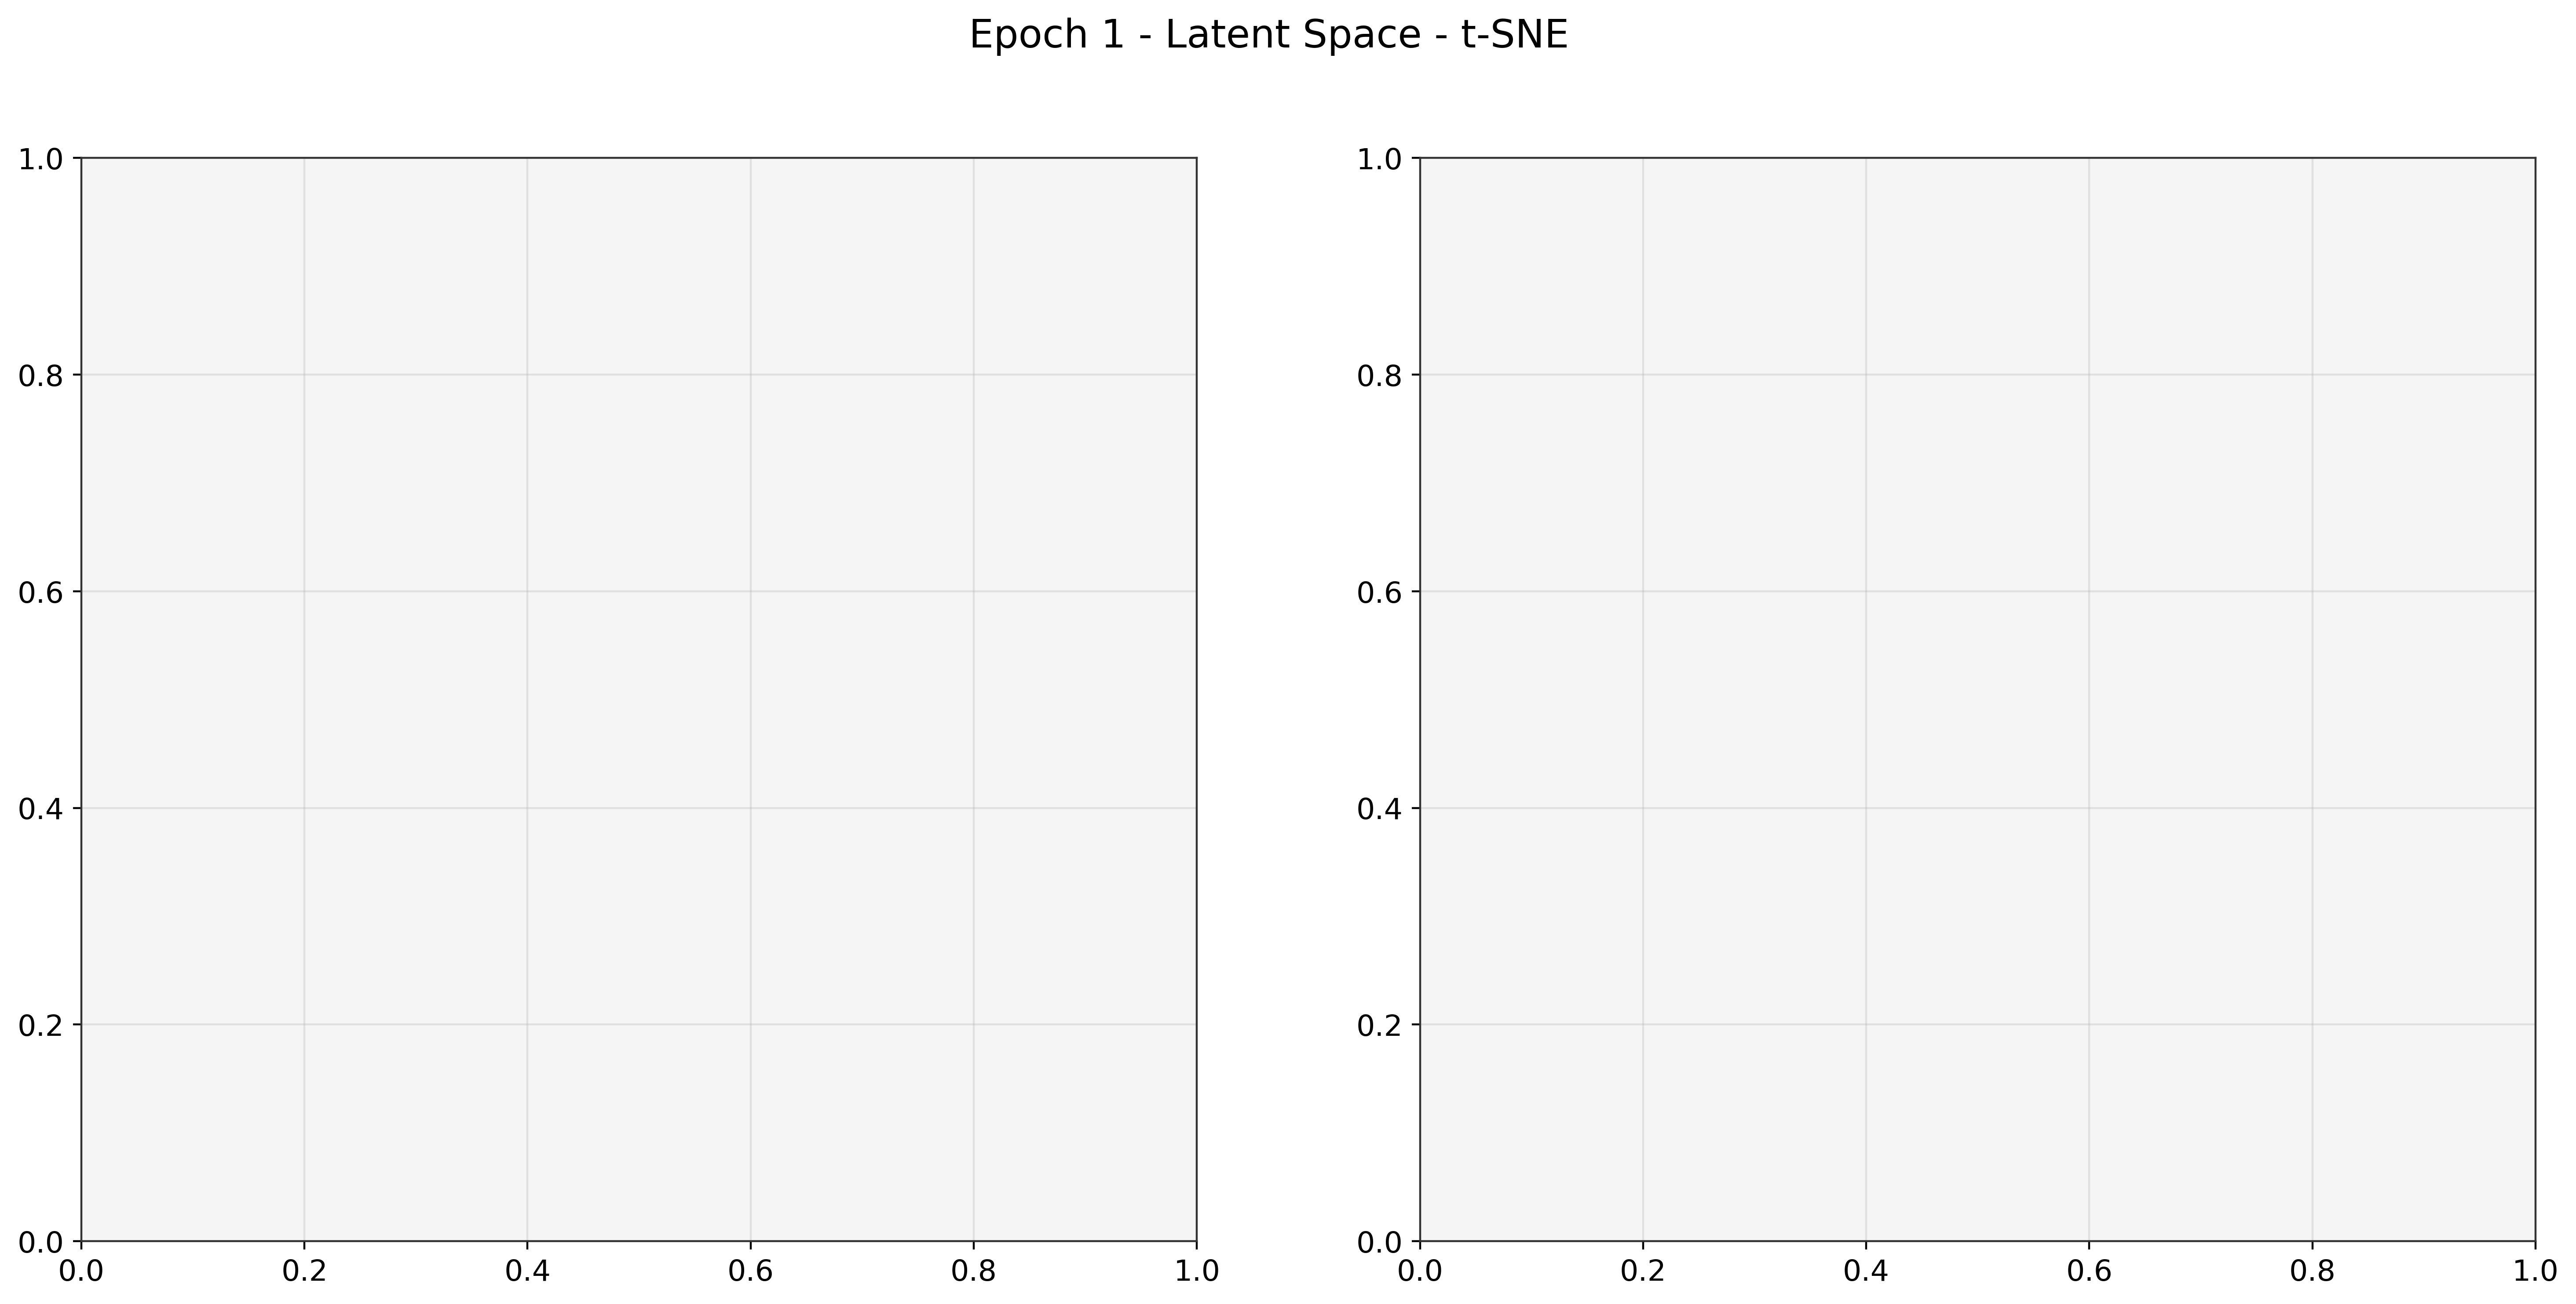

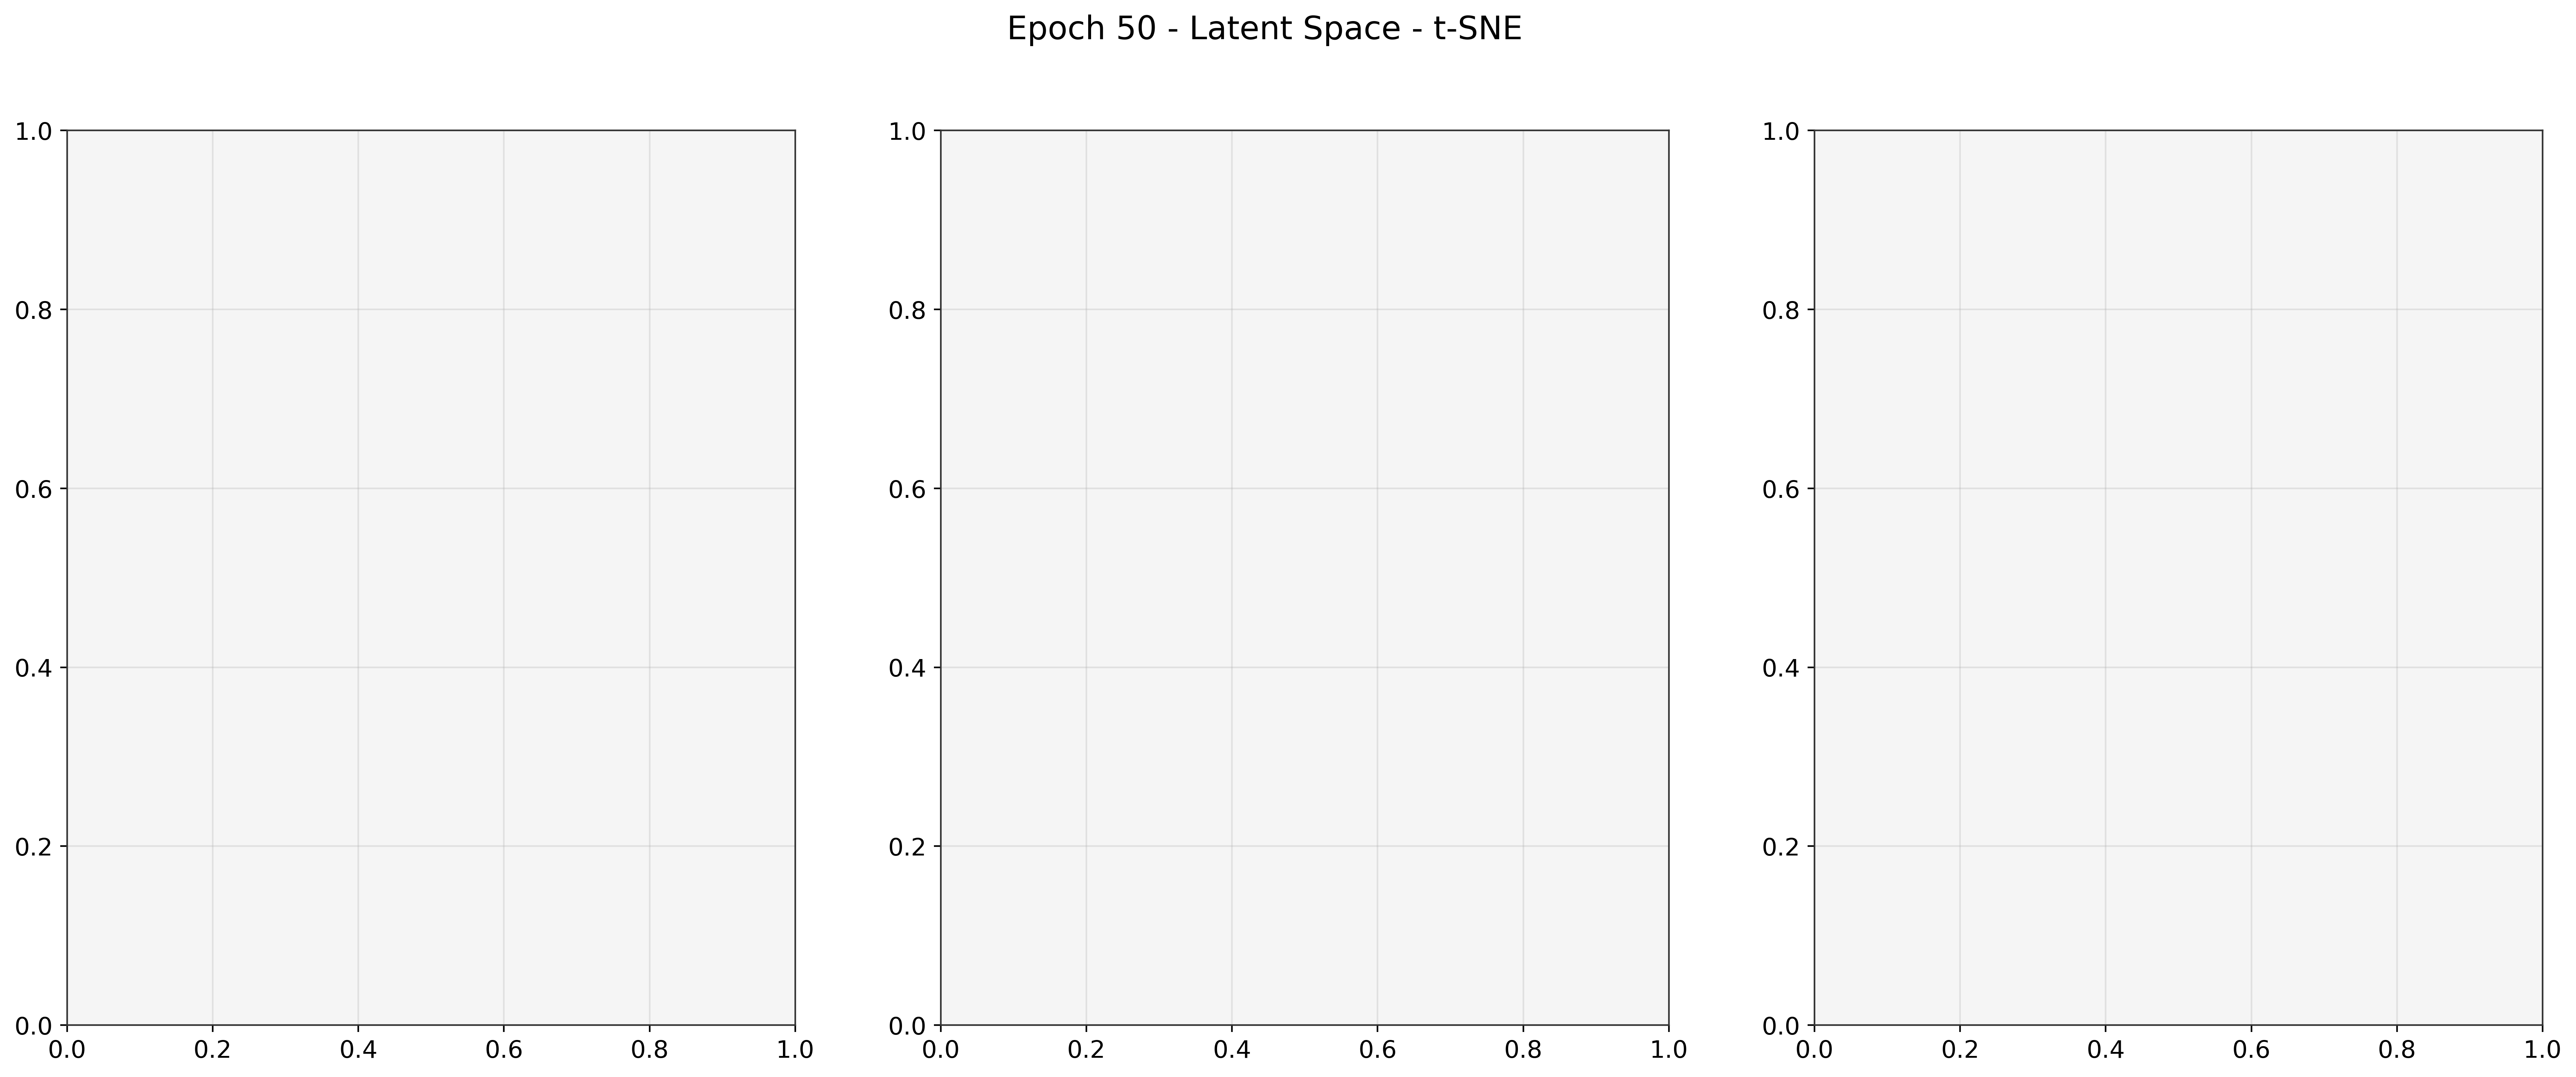

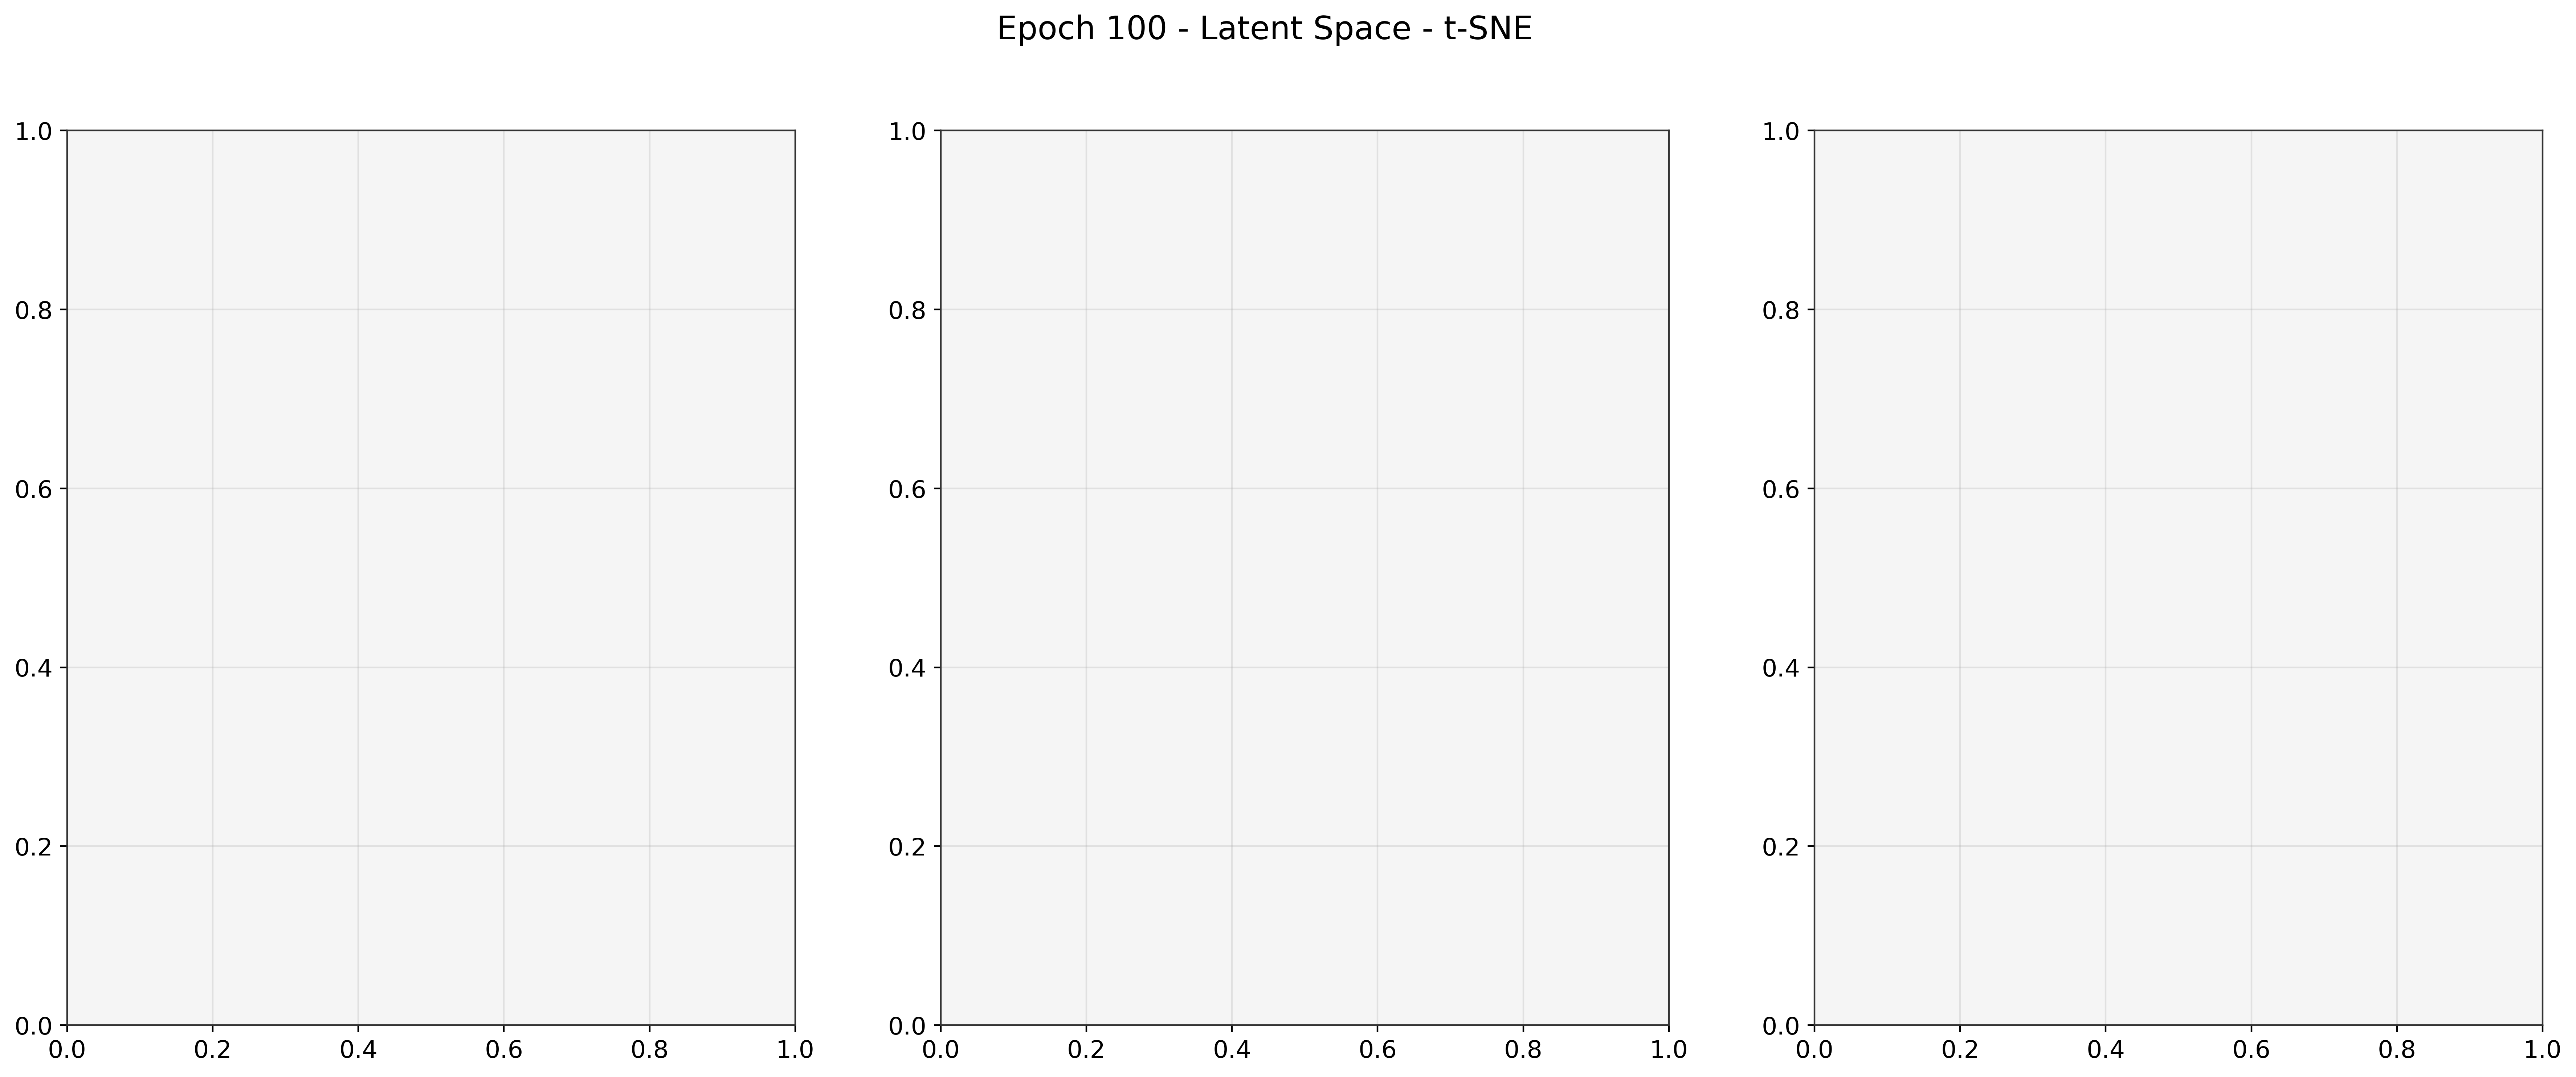

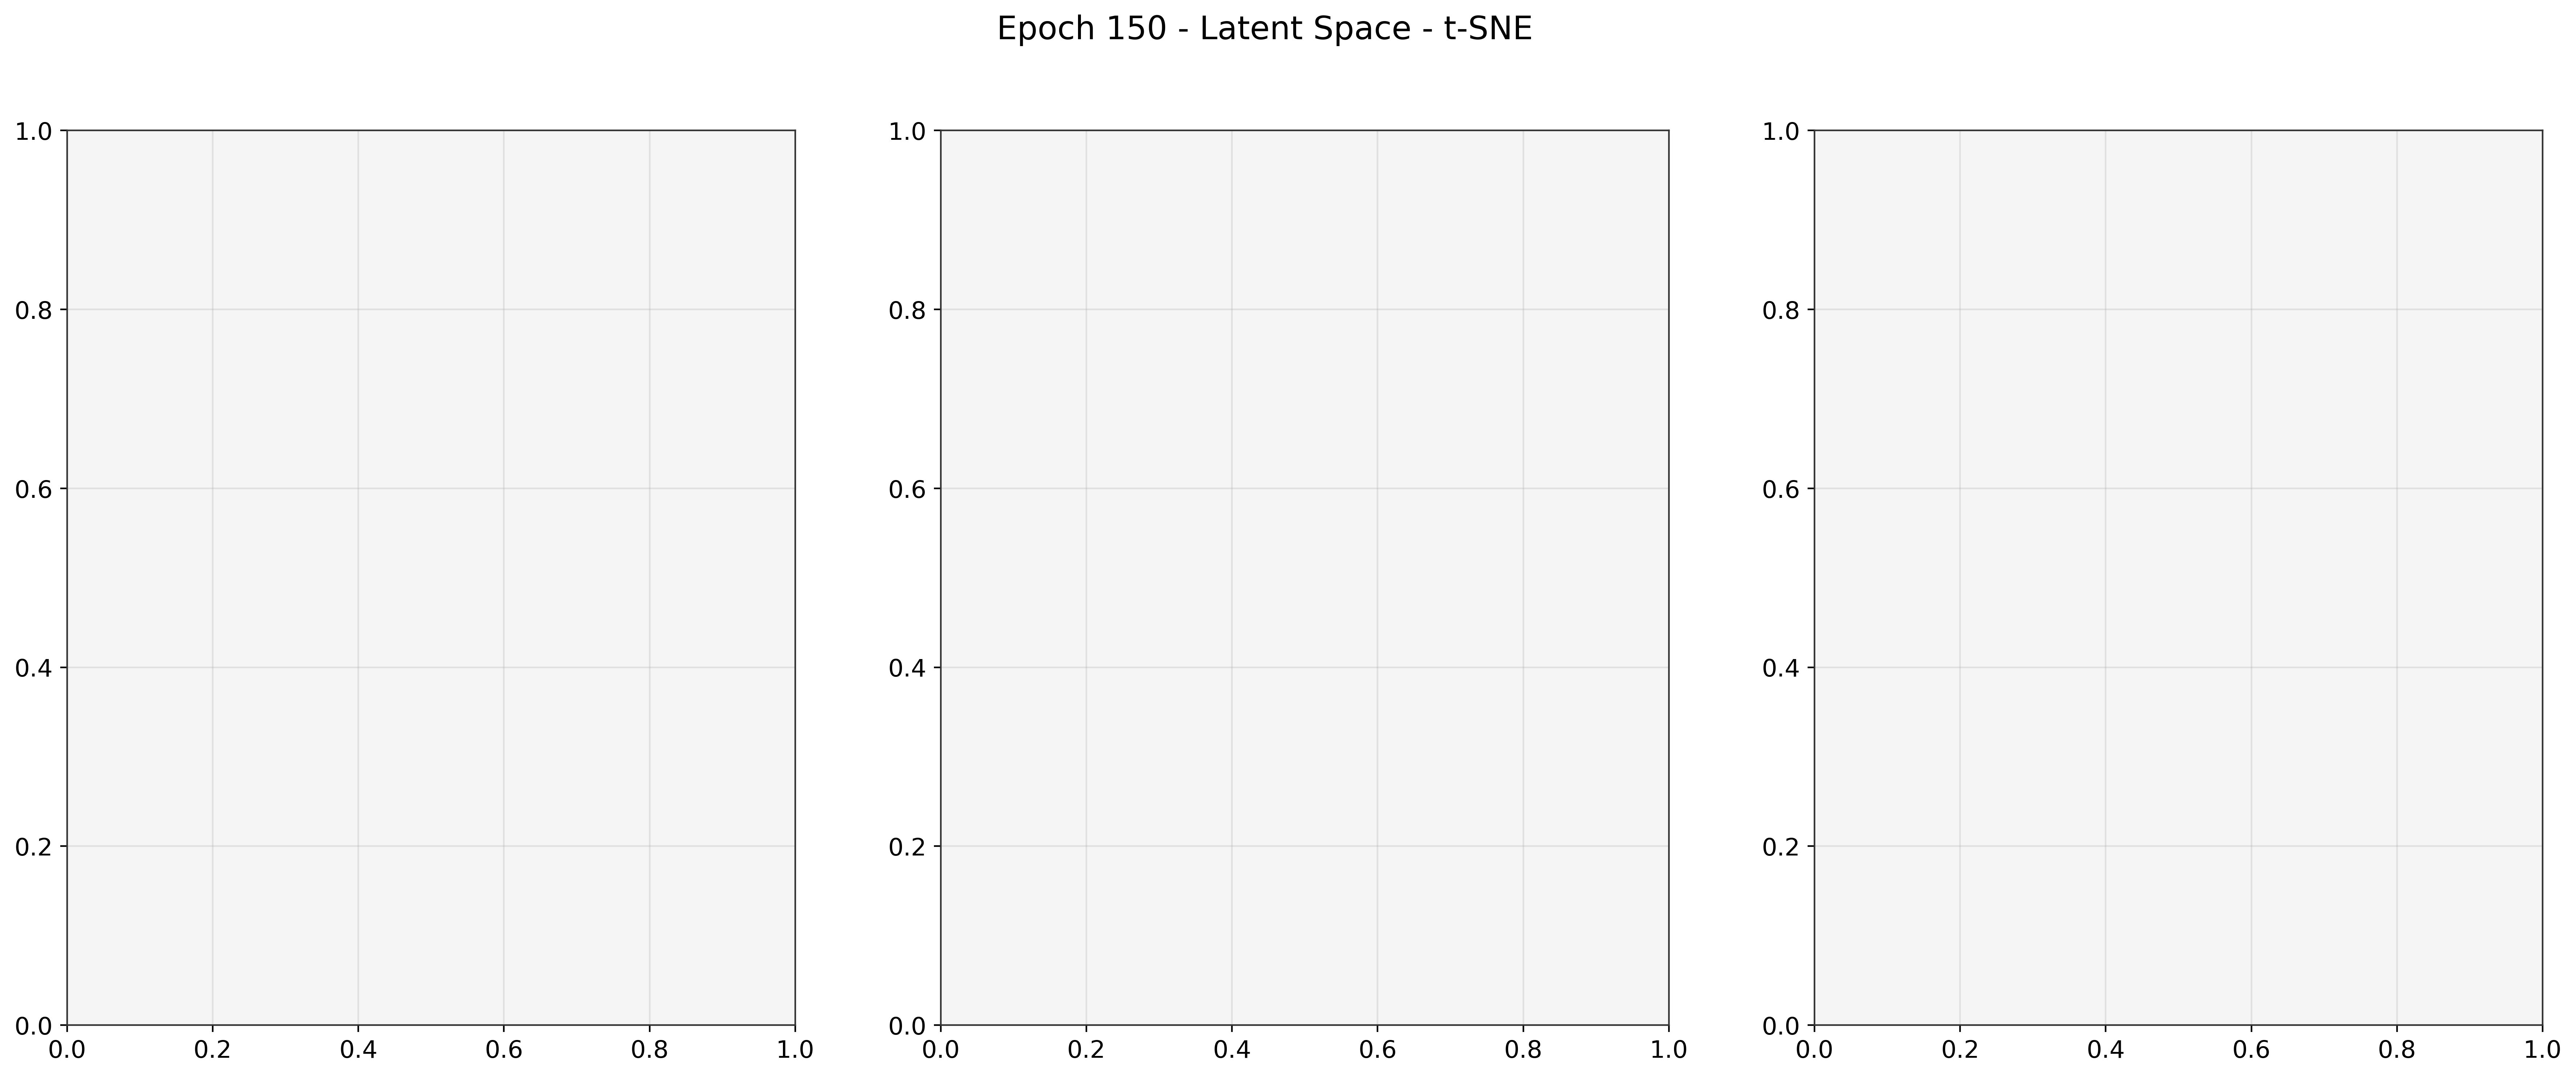

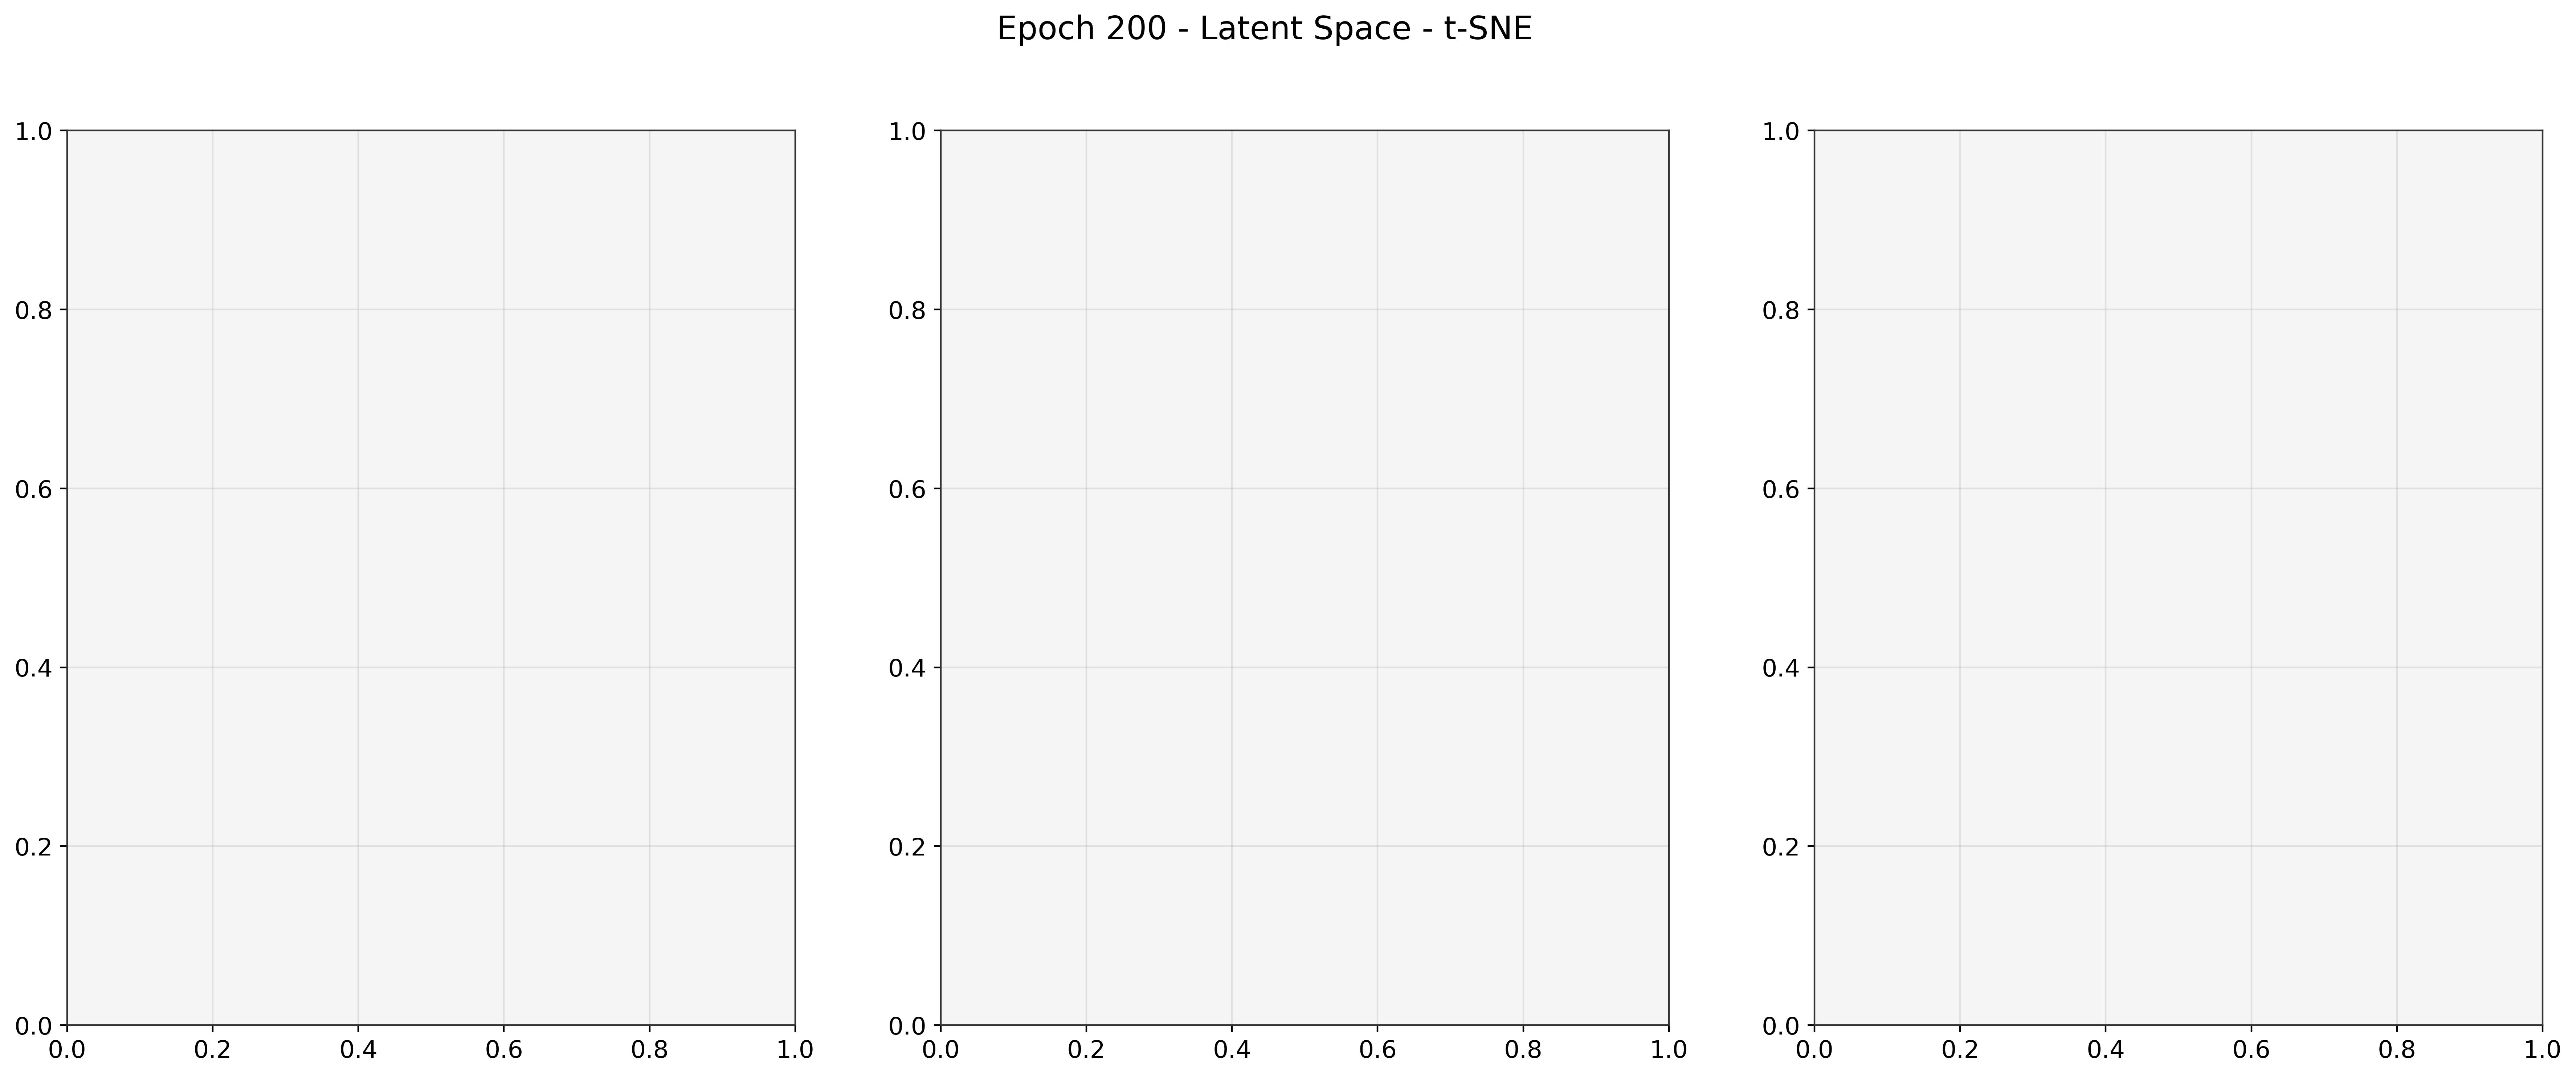

In [5]:
trainer = DGDTrainer(
    config=config,
    device=device,
    verbose=True  # Enable detailed logging
)

# Start training!
print("Starting DGD training...")
print("=" * 60)

# Record start time
training_start_time = time.time()

try:
    results = trainer.train(
        train_loader=train_loader,
        test_loader=test_loader,
        sample_data=sample_data,
        class_names=class_names
    )
    
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    
    print("\\n" + "=" * 60)
    print("Training completed successfully!")
    print(f"⏱Total training time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")
    
    # Extract results
    model = results['model']
    rep_layer = results['rep']
    test_rep_layer = results['test_rep']
    gmm = results['gmm']
    train_losses = results['train_losses']
    test_losses = results['test_losses']
    
    print(f"\\nFinal Results:")
    print(f"  Final train loss: {results['final_train_loss']:.6f}")
    print(f"  Final test loss: {results['final_test_loss']:.6f}")
    print(f"  Best train loss: {min(train_losses):.6f} (epoch {train_losses.index(min(train_losses)) + 1})")
    print(f"  Best test loss: {min(test_losses):.6f} (epoch {test_losses.index(min(test_losses)) + 1})")
    
    # Model information
    decoder_params = sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
    rep_params = sum(p.numel() for p in rep_layer.parameters() if p.requires_grad)
    test_rep_params = sum(p.numel() for p in test_rep_layer.parameters() if p.requires_grad)
    total_params = decoder_params + rep_params + test_rep_params
    
    print(f"\\nModel Statistics:")
    print(f"  Decoder parameters: {decoder_params:,} ({decoder_params/1e6:.2f}M)")
    print(f"  Train representation parameters: {rep_params:,} ({rep_params/1e6:.2f}M)")
    print(f"  Test representation parameters: {test_rep_params:,} ({test_rep_params/1e6:.2f}M)")
    print(f"  Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")
    
    print(f"\\nGMM Information:")
    print(f"  Number of components: {gmm.n_components}")
    print(f"  Covariance type: {gmm.covariance_type}")
    print(f"  Converged: {gmm.converged_}")
    print(f"  Number of iterations: {gmm.n_iter_}")
    
except Exception as e:
    print(f"Training failed with error: {e}")
    import traceback
    traceback.print_exc()
    raise e

print("\\nTraining phase completed!")

## 7. Analyze Training Results

Let's analyze the training results by examining loss curves, reconstruction quality, and model performance.

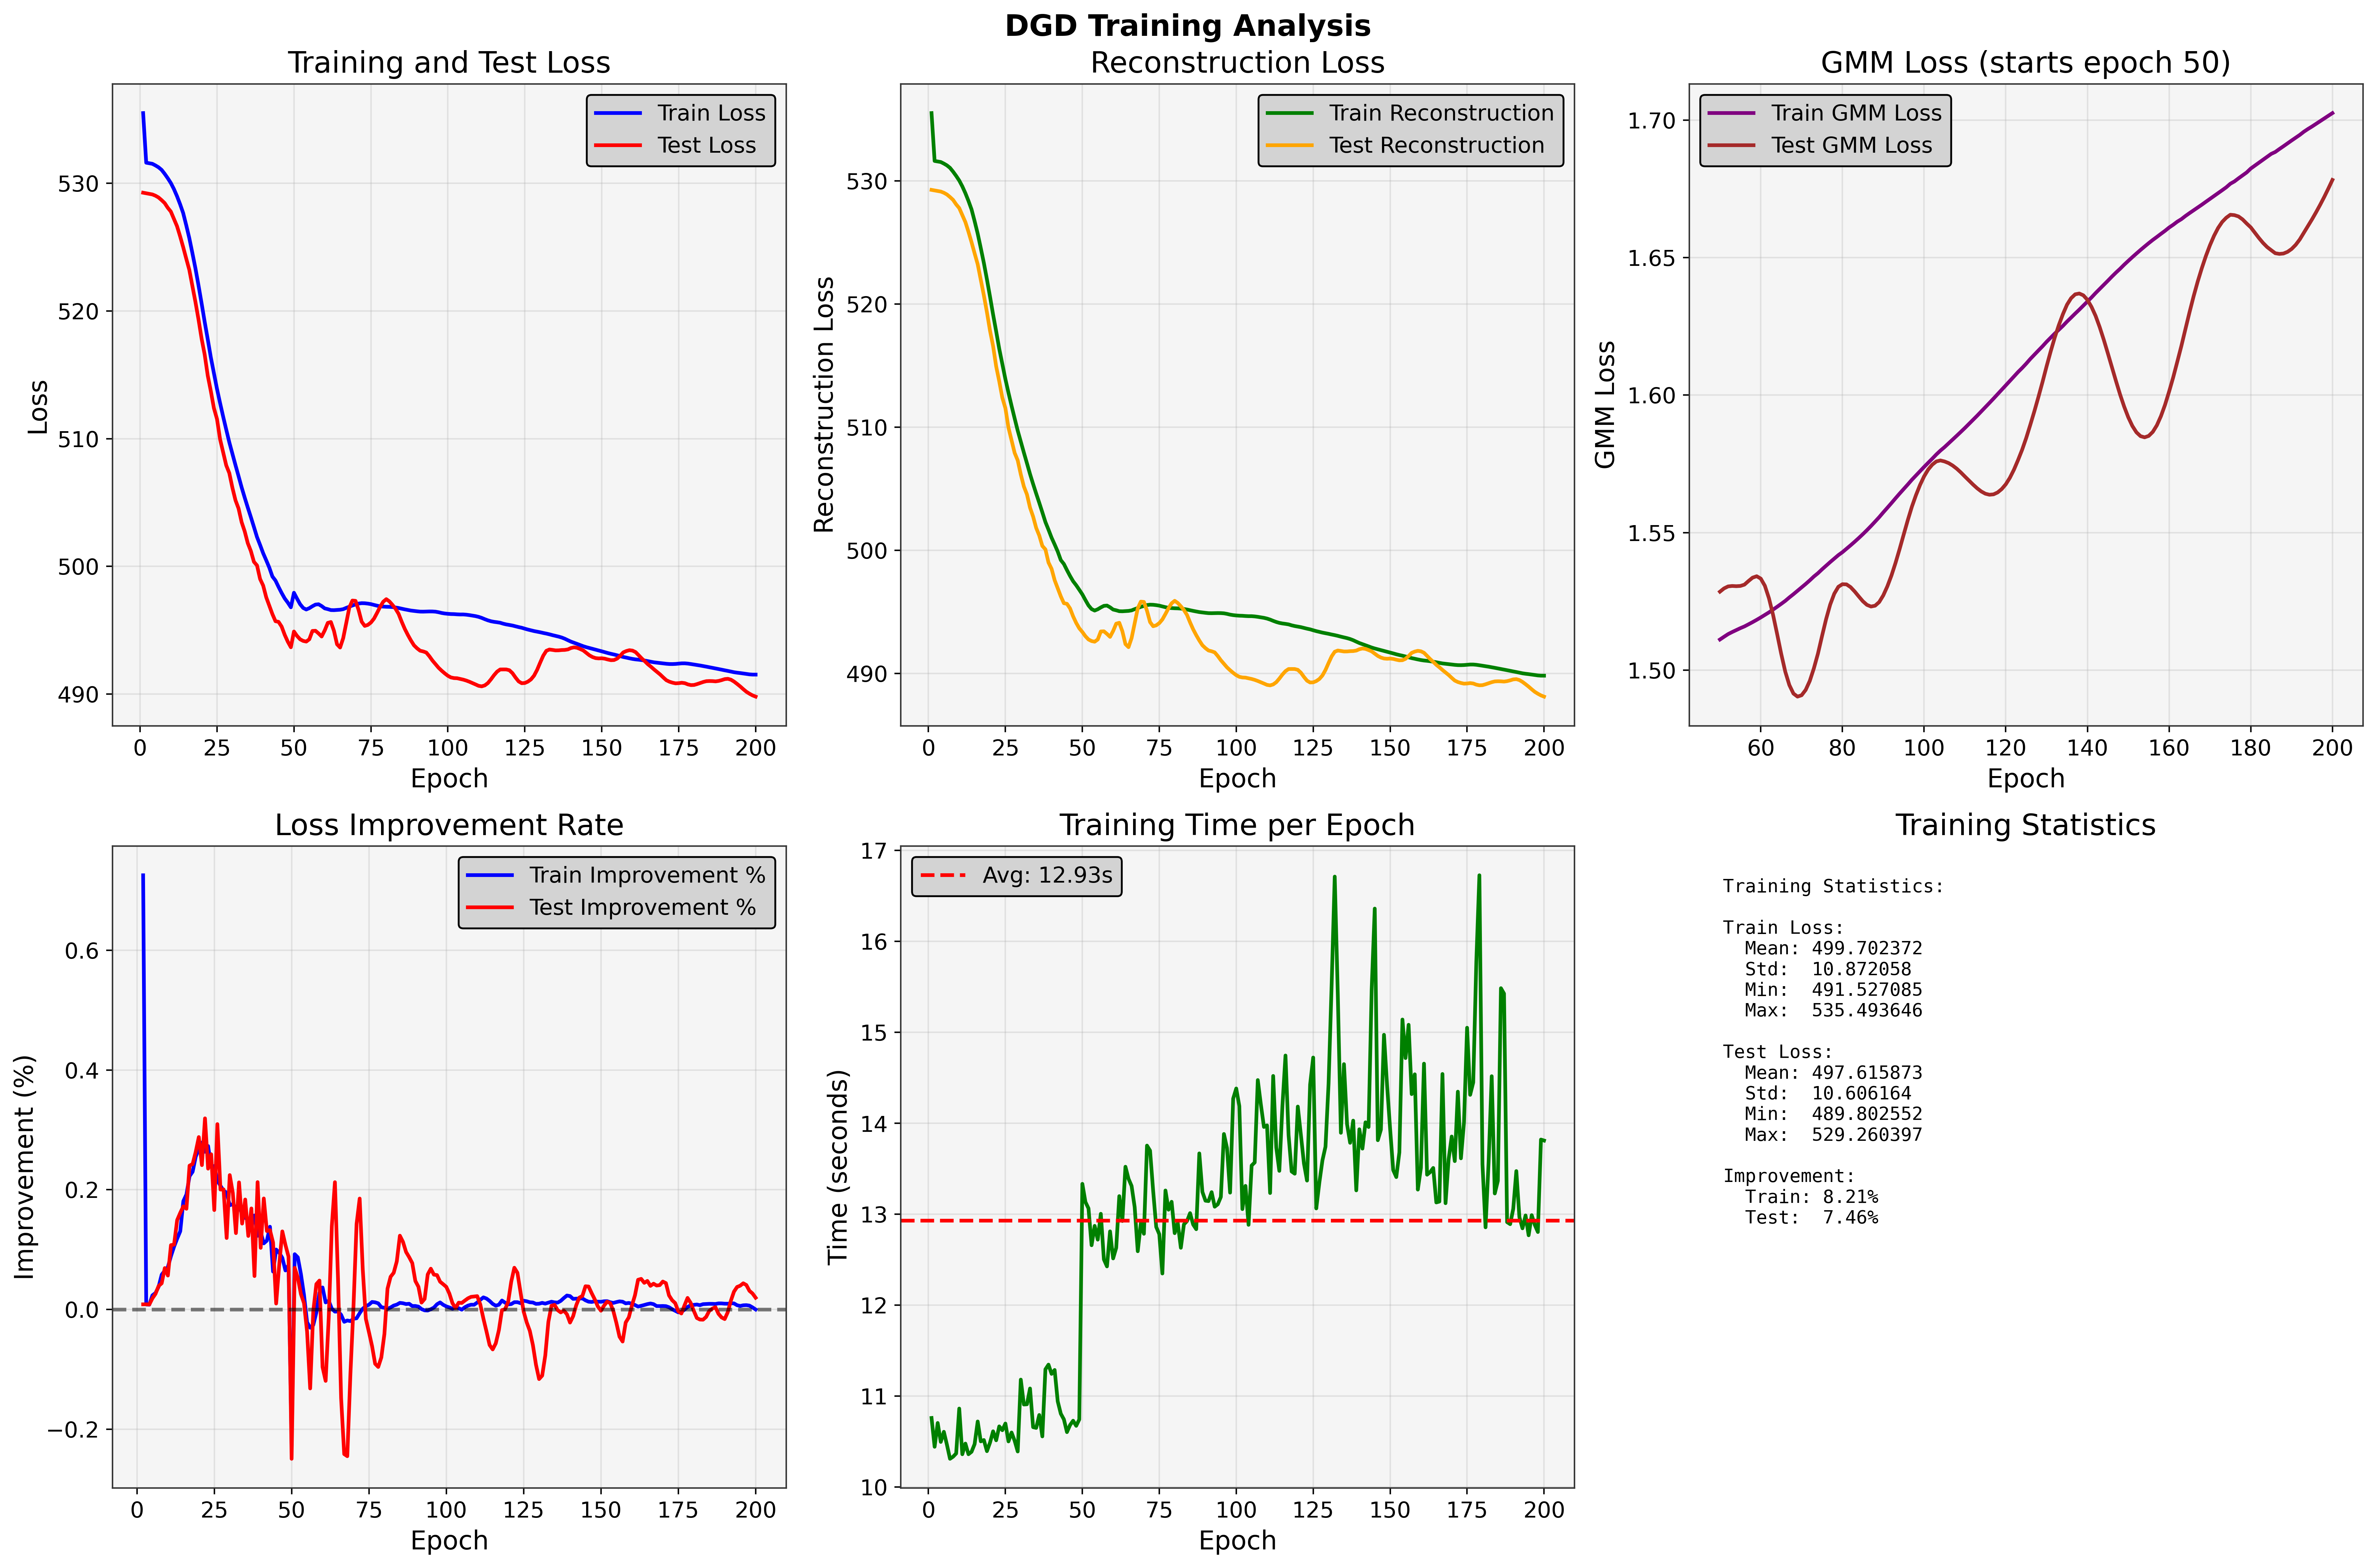

📊 Training Analysis Complete!
- Total epochs: 200
- Training improvement: 8.21%
- Test improvement: 7.46%
- Average epoch time: 12.93 seconds
- GMM fitted: Yes


In [6]:
# Plot comprehensive training analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('DGD Training Analysis', fontsize=16, fontweight='bold')

# 1. Training and Test Loss
axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(range(1, len(test_losses) + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Reconstruction Losses
recon_train_losses = trainer.recon_train_losses
recon_test_losses = trainer.recon_test_losses
axes[0, 1].plot(range(1, len(recon_train_losses) + 1), recon_train_losses, 'g-', label='Train Reconstruction', linewidth=2)
axes[0, 1].plot(range(1, len(recon_test_losses) + 1), recon_test_losses, 'orange', label='Test Reconstruction', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Reconstruction Loss')
axes[0, 1].set_title('Reconstruction Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. GMM Losses (after GMM starts)
gmm_train_losses = trainer.gmm_train_losses
gmm_test_losses = trainer.gmm_test_losses
gmm_start_epoch = config.training.first_epoch_gmm

if len(gmm_train_losses) > 0 and any(x != 0 for x in gmm_train_losses):
    non_zero_epochs = [i+1 for i, x in enumerate(gmm_train_losses) if x != 0]
    non_zero_train = [x for x in gmm_train_losses if x != 0]
    non_zero_test = [gmm_test_losses[i] for i, x in enumerate(gmm_train_losses) if x != 0]
    
    axes[0, 2].plot(non_zero_epochs, non_zero_train, 'purple', label='Train GMM Loss', linewidth=2)
    axes[0, 2].plot(non_zero_epochs, non_zero_test, 'brown', label='Test GMM Loss', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('GMM Loss')
    axes[0, 2].set_title(f'GMM Loss (starts epoch {gmm_start_epoch})')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'GMM not fitted yet\\nor no GMM loss', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('GMM Loss')

# 4. Loss Improvement Rate
if len(train_losses) > 1:
    train_improvements = [((train_losses[i-1] - train_losses[i]) / train_losses[i-1] * 100) if train_losses[i-1] != 0 else 0 
                         for i in range(1, len(train_losses))]
    test_improvements = [((test_losses[i-1] - test_losses[i]) / test_losses[i-1] * 100) if test_losses[i-1] != 0 else 0 
                        for i in range(1, len(test_losses))]
    
    axes[1, 0].plot(range(2, len(train_losses) + 1), train_improvements, 'b-', label='Train Improvement %', linewidth=2)
    axes[1, 0].plot(range(2, len(test_losses) + 1), test_improvements, 'r-', label='Test Improvement %', linewidth=2)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Improvement (%)')
    axes[1, 0].set_title('Loss Improvement Rate')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# 5. Epoch Times
epoch_times = trainer.epoch_times
if len(epoch_times) > 0:
    axes[1, 1].plot(range(1, len(epoch_times) + 1), epoch_times, 'green', linewidth=2)
    axes[1, 1].axhline(y=np.mean(epoch_times), color='red', linestyle='--', label=f'Avg: {np.mean(epoch_times):.2f}s')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].set_title('Training Time per Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Summary Statistics
train_mean = np.mean(train_losses)
train_std = np.std(train_losses)
test_mean = np.mean(test_losses)
test_std = np.std(test_losses)

stats_text = f"""Training Statistics:

Train Loss:
  Mean: {train_mean:.6f}
  Std:  {train_std:.6f}
  Min:  {min(train_losses):.6f}
  Max:  {max(train_losses):.6f}

Test Loss:
  Mean: {test_mean:.6f}
  Std:  {test_std:.6f}
  Min:  {min(test_losses):.6f}
  Max:  {max(test_losses):.6f}

Improvement:
  Train: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%
  Test:  {((test_losses[0] - test_losses[-1]) / test_losses[0] * 100):.2f}%
"""

axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes, fontsize=10, 
                verticalalignment='top', fontfamily='monospace')
axes[1, 2].set_title('Training Statistics')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("📊 Training Analysis Complete!")
print(f"- Total epochs: {len(train_losses)}")
print(f"- Training improvement: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")
print(f"- Test improvement: {((test_losses[0] - test_losses[-1]) / test_losses[0] * 100):.2f}%")
print(f"- Average epoch time: {np.mean(epoch_times):.2f} seconds")
print(f"- GMM fitted: {'Yes' if gmm.converged_ else 'No'}")

## 8. Model Evaluation and Testing

Let's evaluate the trained model by examining reconstruction quality and computing various metrics.

🔍 Evaluating trained DGD model...
- Reconstruction MSE - Train: 0.645015 ± 0.131636
- Reconstruction MSE - Test: 0.618011 ± 0.150234


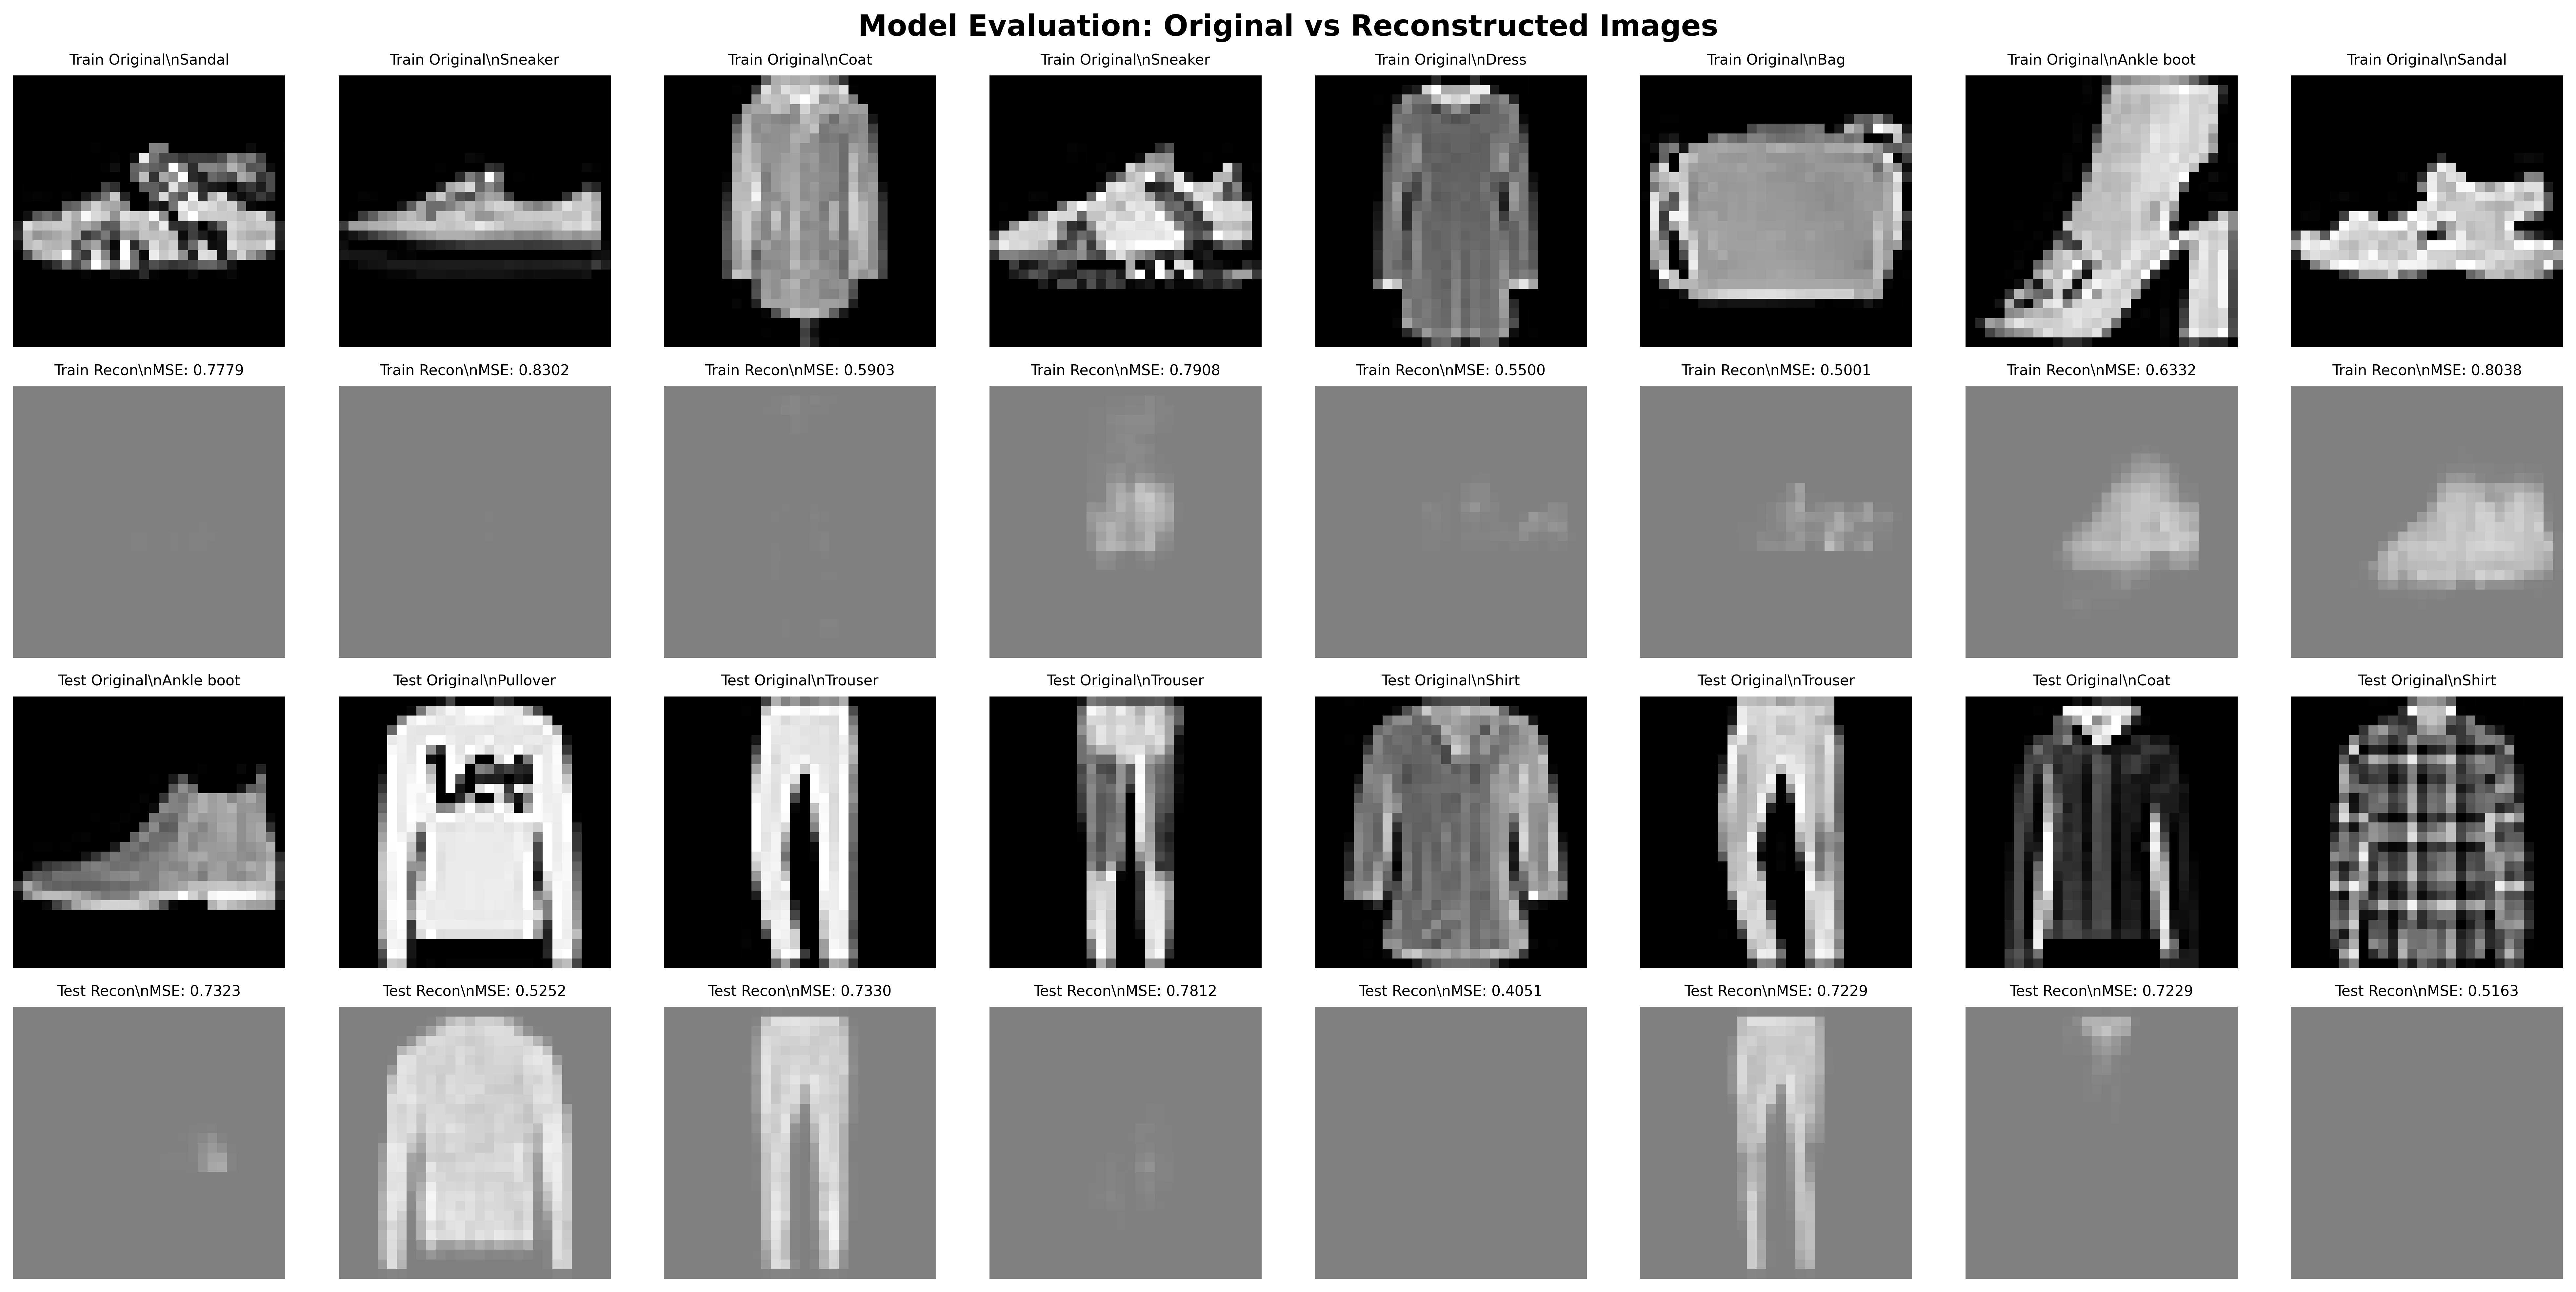

\n📊 Comprehensive Model Evaluation:
\n🎯 Reconstruction Quality:
  Train samples: 60000
  Test samples: 10000
  Sample train MSE: 0.645015 ± 0.131636
  Sample test MSE: 0.618011 ± 0.150234
\n🌌 Latent Space Analysis:
  Latent dimension: 2
  Train latent norm: 0.6868 ± 0.3652
  Test latent norm: 0.6811 ± 0.3661
  Latent range: [-1.128, 1.254]
\n🎲 GMM Evaluation:
  Number of components: 20
  Covariance type: full
  Converged: True
  Iterations: 2
  Train log-likelihood: -1.6353 ± 0.7778
  Test log-likelihood: -1.6231 ± 0.8168
  Component weights: tensor([0.0613, 0.0428, 0.0535, 0.0563, 0.0627, 0.0417, 0.0390, 0.0598, 0.0506,
        0.0538, 0.0418, 0.0546, 0.0413, 0.0381, 0.0406, 0.0455, 0.0529, 0.0622,
        0.0431, 0.0585], device='cuda:0')
  Effective components: 20 / 20
\n✅ Model evaluation completed!


In [7]:
# Evaluate the trained model
print("🔍 Evaluating trained DGD model...")

# Set model to evaluation mode
model.eval()

# Test reconstruction quality on sample data
with torch.no_grad():
    # Get sample data
    indices_train, images_train, labels_train, indices_test, images_test, labels_test = sample_data
    
    # Move to device
    indices_train = indices_train.to(device)
    images_train = images_train.to(device)
    indices_test = indices_test.to(device)
    images_test = images_test.to(device)
    
    # Generate reconstructions
    z_train = rep_layer(indices_train)
    recon_train = model.decoder(z_train)
    
    z_test = test_rep_layer(indices_test)
    recon_test = model.decoder(z_test)
    
    # Compute reconstruction errors
    train_mse = F.mse_loss(recon_train, images_train, reduction='none').mean(dim=[1,2,3])
    test_mse = F.mse_loss(recon_test, images_test, reduction='none').mean(dim=[1,2,3])
    
    print(f"- Reconstruction MSE - Train: {train_mse.mean():.6f} ± {train_mse.std():.6f}")
    print(f"- Reconstruction MSE - Test: {test_mse.mean():.6f} ± {test_mse.std():.6f}")

# Visualize reconstructions
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
fig.suptitle('Model Evaluation: Original vs Reconstructed Images', fontsize=16, fontweight='bold')

# Convert tensors to CPU and numpy for plotting
images_train_cpu = images_train.cpu()
recon_train_cpu = recon_train.cpu()
images_test_cpu = images_test.cpu()
recon_test_cpu = recon_test.cpu()
labels_train_cpu = labels_train.cpu()
labels_test_cpu = labels_test.cpu()

for i in range(8):
    # Original train images
    img = images_train_cpu[i].squeeze()
    img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
    label = labels_train_cpu[i].item()
    axes[0, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'Train Original\\n{class_names[label]}', fontsize=8)
    axes[0, i].axis('off')
    
    # Reconstructed train images
    img = recon_train_cpu[i].squeeze()
    img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
    mse = train_mse[i].item()
    axes[1, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Train Recon\\nMSE: {mse:.4f}', fontsize=8)
    axes[1, i].axis('off')
    
    # Original test images
    img = images_test_cpu[i].squeeze()
    img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
    label = labels_test_cpu[i].item()
    axes[2, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[2, i].set_title(f'Test Original\\n{class_names[label]}', fontsize=8)
    axes[2, i].axis('off')
    
    # Reconstructed test images
    img = recon_test_cpu[i].squeeze()
    img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
    mse = test_mse[i].item()
    axes[3, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[3, i].set_title(f'Test Recon\\nMSE: {mse:.4f}', fontsize=8)
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()

# Compute comprehensive evaluation metrics
print("\\n📊 Comprehensive Model Evaluation:")

# 1. Overall reconstruction quality
total_train_samples = len(train_loader.dataset)
total_test_samples = len(test_loader.dataset)

print(f"\\n🎯 Reconstruction Quality:")
print(f"  Train samples: {total_train_samples}")
print(f"  Test samples: {total_test_samples}")
print(f"  Sample train MSE: {train_mse.mean():.6f} ± {train_mse.std():.6f}")
print(f"  Sample test MSE: {test_mse.mean():.6f} ± {test_mse.std():.6f}")

# 2. Latent space analysis
z_train_norm = torch.norm(z_train, dim=1)
z_test_norm = torch.norm(z_test, dim=1)

print(f"\\n🌌 Latent Space Analysis:")
print(f"  Latent dimension: {z_train.shape[1]}")
print(f"  Train latent norm: {z_train_norm.mean():.4f} ± {z_train_norm.std():.4f}")
print(f"  Test latent norm: {z_test_norm.mean():.4f} ± {z_test_norm.std():.4f}")
print(f"  Latent range: [{z_train.min():.3f}, {z_train.max():.3f}]")

# 3. GMM evaluation
if gmm.converged_:
    # Compute log-likelihood of representations
    train_log_likelihood = gmm.score_samples(z_train)
    test_log_likelihood = gmm.score_samples(z_test)
    
    print(f"\\n🎲 GMM Evaluation:")
    print(f"  Number of components: {gmm.n_components}")
    print(f"  Covariance type: {gmm.covariance_type}")
    print(f"  Converged: {gmm.converged_}")
    print(f"  Iterations: {gmm.n_iter_}")
    print(f"  Train log-likelihood: {train_log_likelihood.mean():.4f} ± {train_log_likelihood.std():.4f}")
    print(f"  Test log-likelihood: {test_log_likelihood.mean():.4f} ± {test_log_likelihood.std():.4f}")
    
    # Component weights
    weights = gmm.weights_
    print(f"  Component weights: {weights}")
    print(f"  Effective components: {(weights > 0.01).sum()} / {len(weights)}")
else:
    print(f"\\n⚠️ GMM did not converge (iterations: {gmm.n_iter_})")

print("\\n✅ Model evaluation completed!")

## 9. Generate Samples from Trained Model

Now let's generate new samples using the trained GMM and explore the latent space capabilities.

🎨 Generating samples from trained DGD model...
- Generated 32 samples from GMM
- Sample shape: torch.Size([32, 1, 28, 28])
- Component distribution: [2 2 3 1 3 2 3 2 2 0 1 2 0 1 2 0 2 1 2 1]


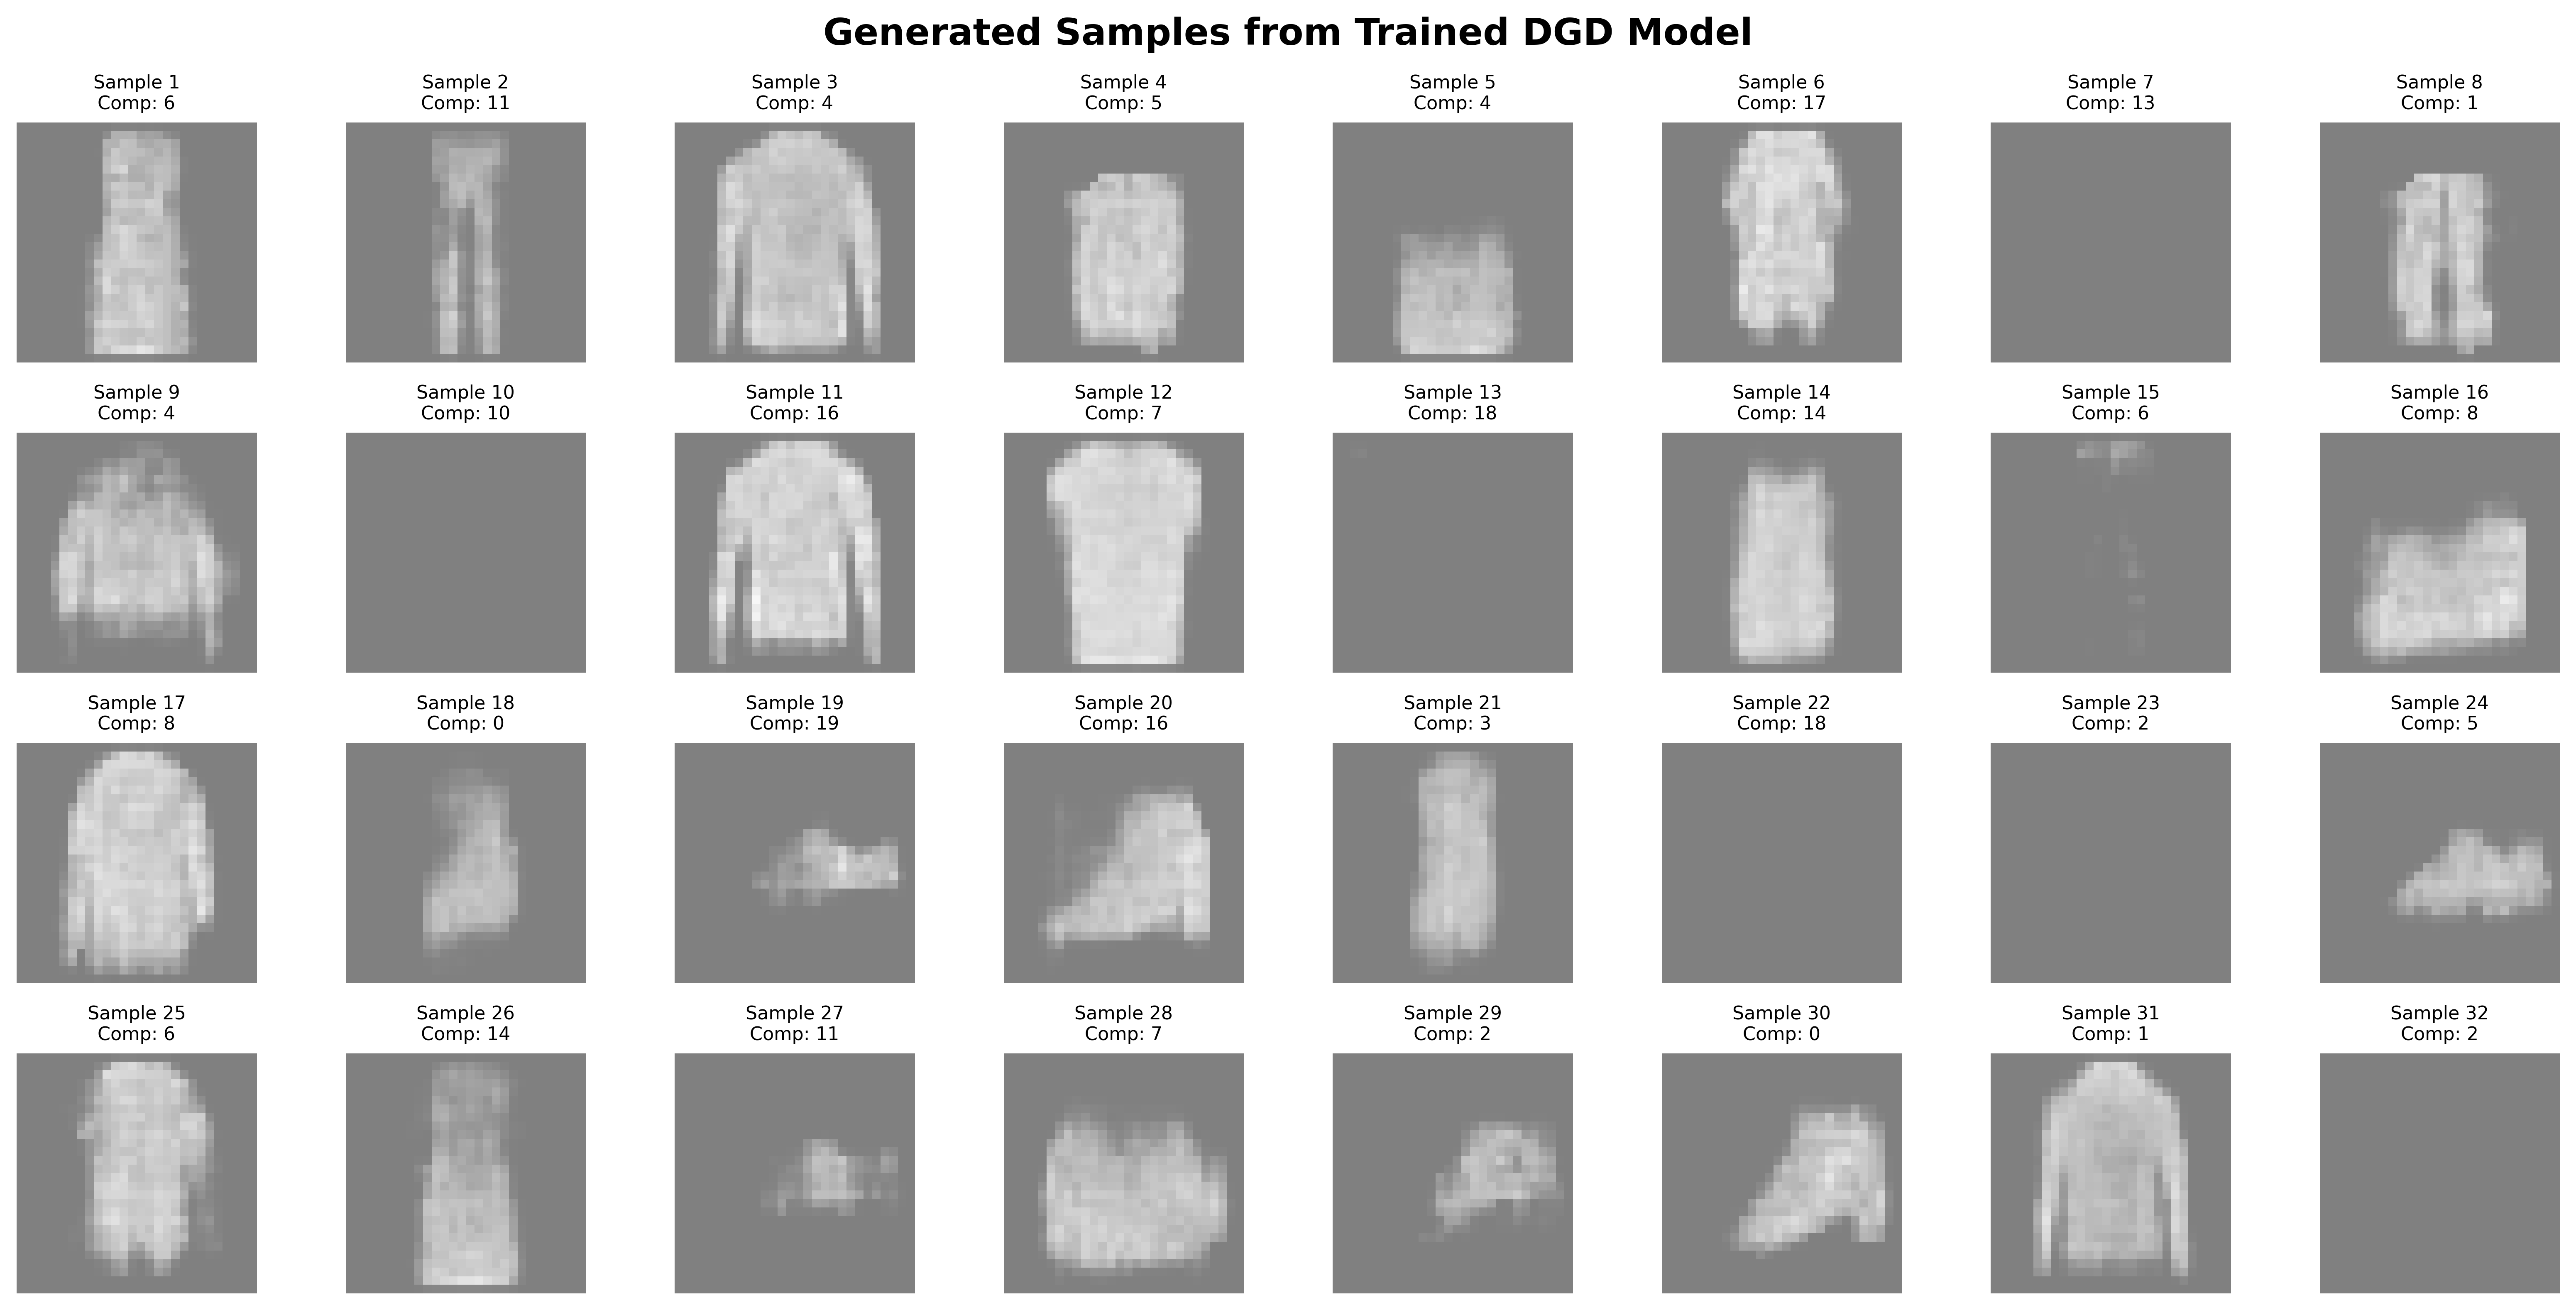


🎯 Generating samples from individual GMM components...


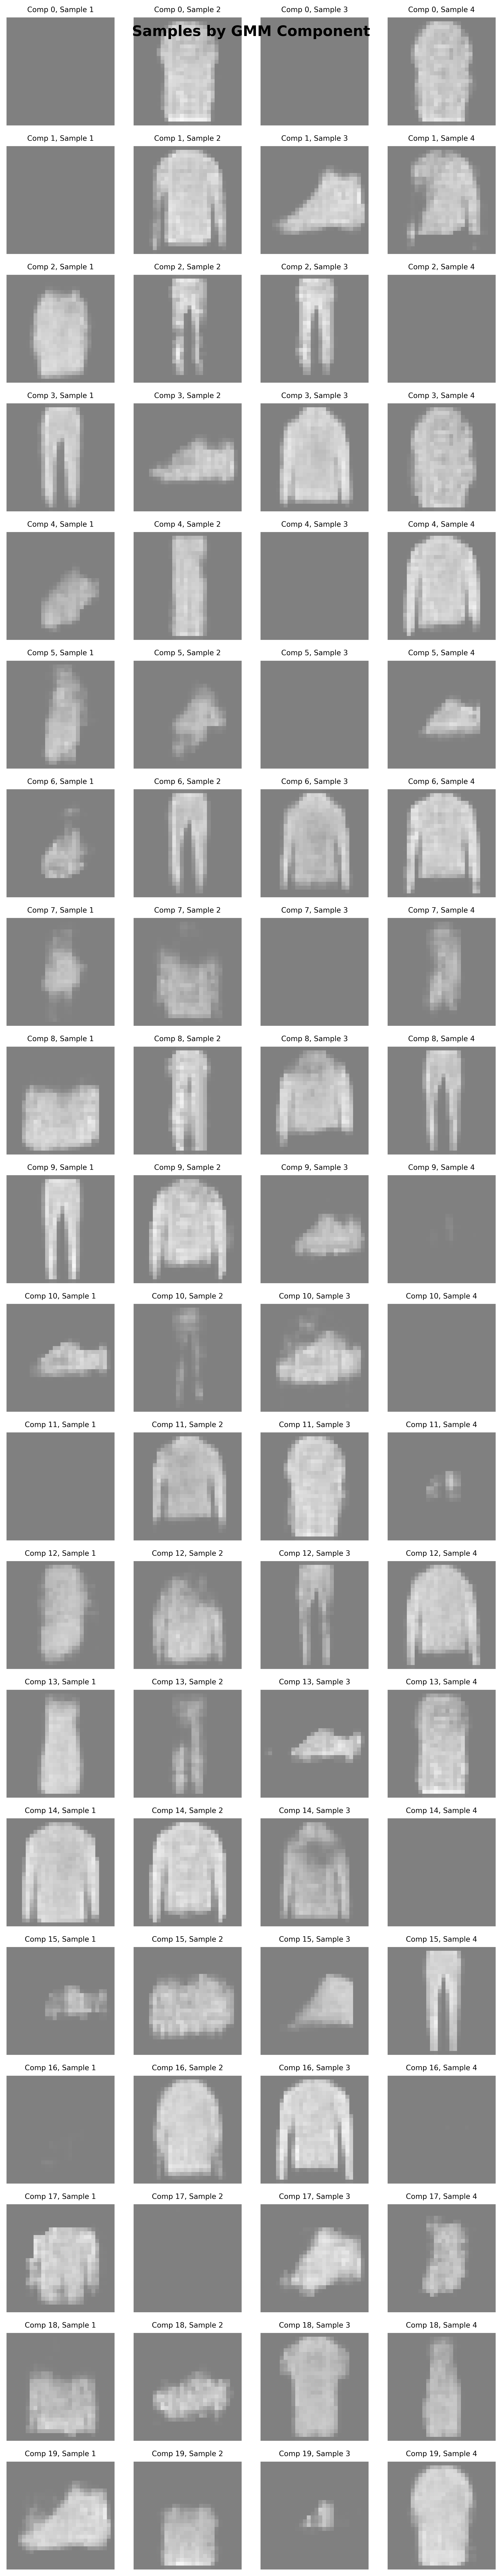

In [8]:
# Generate samples from the trained model
print("🎨 Generating samples from trained DGD model...")

if gmm.converged_:
    with torch.no_grad():
        # 1. Sample from GMM
        n_samples = 32
        z_samples, component_labels = gmm.sample(n_samples)
        
        # Generate images from samples
        generated_images = model.decoder(z_samples)
        
        print(f"- Generated {n_samples} samples from GMM")
        print(f"- Sample shape: {generated_images.shape}")
        print(f"- Component distribution: {np.bincount(component_labels.cpu().numpy())}")
        
        # Visualize generated samples
        fig, axes = plt.subplots(4, 8, figsize=(16, 8))
        fig.suptitle('Generated Samples from Trained DGD Model', fontsize=16, fontweight='bold')
        
        generated_images_cpu = generated_images.cpu()
        component_labels_cpu = component_labels.cpu()
        
        for i in range(min(32, n_samples)):
            row = i // 8
            col = i % 8
            
            img = generated_images_cpu[i].squeeze()
            img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
            component = component_labels_cpu[i].item()
            
            axes[row, col].imshow(img, cmap='gray', vmin=0, vmax=1)
            axes[row, col].set_title(f'Sample {i+1}\nComp: {component}', fontsize=8)
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 2. Sample from each GMM component separately
        print("\n🎯 Generating samples from individual GMM components...")
        
        def sample_from_component(gmm, n_samples, component_idx):
            """Sample n_samples from a specific GMM component."""
            # Get the mean and covariance for the specific component
            mean = gmm.means_[component_idx]
            
            # Handle different covariance types
            if gmm.covariance_type == 'full':
                cov = gmm.covariances_[component_idx]
            elif gmm.covariance_type == 'diag':
                cov = torch.diag_embed(gmm.covariances_[component_idx])
            elif gmm.covariance_type == 'spherical':
                cov = torch.eye(gmm.n_features, device=gmm.device) * gmm.covariances_[component_idx]
            elif gmm.covariance_type == 'tied_full':
                cov = gmm.covariances_
            elif gmm.covariance_type == 'tied_diag':
                cov = torch.diag_embed(gmm.covariances_)
            elif gmm.covariance_type == 'tied_spherical':
                cov = torch.eye(gmm.n_features, device=gmm.device) * gmm.covariances_
            else:
                raise ValueError(f"Unsupported covariance type: {gmm.covariance_type}")
            
            # Sample from the multivariate normal distribution
            dist = torch.distributions.MultivariateNormal(mean, cov)
            samples = dist.sample((n_samples,))
            return samples
        
        # Generate samples from each component
        n_per_component = 4
        fig, axes = plt.subplots(gmm.n_components, n_per_component, figsize=(n_per_component*2, gmm.n_components*2))
        fig.suptitle('Samples by GMM Component', fontsize=16, fontweight='bold')
        
        for comp in range(gmm.n_components):
            # Sample from specific component
            z_comp = sample_from_component(gmm, n_per_component, comp)
            imgs_comp = model.decoder(z_comp)
            
            for j in range(n_per_component):
                img = imgs_comp[j].cpu().squeeze()
                img = torch.clamp((img + 1) / 2, 0, 1)
                
                if gmm.n_components == 1:
                    axes[j].imshow(img, cmap='gray', vmin=0, vmax=1)
                    axes[j].set_title(f'Comp {comp}, Sample {j+1}', fontsize=8)
                    axes[j].axis('off')
                else:
                    axes[comp, j].imshow(img, cmap='gray', vmin=0, vmax=1)
                    axes[comp, j].set_title(f'Comp {comp}, Sample {j+1}', fontsize=8)
                    axes[comp, j].axis('off')
        
        plt.tight_layout()
        plt.show()
        
else:
    print("⚠️ GMM did not converge - cannot generate meaningful samples")
    print("💡 Try training for more epochs or adjusting GMM parameters")

## 10. Save and Export Model

Finally, let's save the trained model components and demonstrate how to load them for future use.

In [9]:
# Save the trained model components
print("💾 Saving trained DGD model components...")

# Create model save directory
model_dir = project_root / "models" / "dgd_demo"
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Model save directory: {model_dir}")

# 1. Save model state dictionaries
torch.save(model.decoder.state_dict(), model_dir / "decoder.pth")
torch.save(rep_layer.state_dict(), model_dir / "train_representation.pth")
torch.save(test_rep_layer.state_dict(), model_dir / "test_representation.pth")

print("- Saved PyTorch model state dictionaries")

# 2. Save GMM model
import pickle
with open(model_dir / "gmm.pkl", "wb") as f:
    pickle.dump(gmm, f)

print("- Saved GMM model")

# 3. Save configuration
OmegaConf.save(config, model_dir / "config.yaml")

print("- Saved configuration")

# 4. Save training results
training_results = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'recon_train_losses': trainer.recon_train_losses,
    'recon_test_losses': trainer.recon_test_losses,
    'gmm_train_losses': trainer.gmm_train_losses,
    'gmm_test_losses': trainer.gmm_test_losses,
    'epoch_times': trainer.epoch_times,
    'final_train_loss': results['final_train_loss'],
    'final_test_loss': results['final_test_loss'],
    'total_time': results['total_time']
}

torch.save(training_results, model_dir / "training_results.pth")

print("- Saved training results")

# 5. Save model metadata
metadata = {
    'model_type': 'DGD',
    'dataset': config.data.dataset,
    'epochs_trained': len(train_losses),
    'latent_dim': config.model.representation.n_features,
    'decoder_params': sum(p.numel() for p in model.decoder.parameters()),
    'rep_params': sum(p.numel() for p in rep_layer.parameters()),
    'gmm_components': gmm.n_components,
    'gmm_converged': gmm.converged_,
    'training_date': time.strftime('%Y-%m-%d %H:%M:%S'),
    'device_used': str(device),
    'pytorch_version': torch.__version__
}

torch.save(metadata, model_dir / "metadata.pth")

print("- Saved model metadata")

# List all saved files
saved_files = list(model_dir.glob("*"))
print(f"\\n📁 Saved files ({len(saved_files)} total):")
for file in saved_files:
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  {file.name}: {size_mb:.2f} MB")

print("\\n" + "="*60)
print("🔄 Demonstrating Model Loading...")

# Demonstrate loading the saved model
def load_dgd_model(model_dir, device):
    """Load a saved DGD model from directory."""
    print(f"Loading DGD model from {model_dir}...")
    
    # Load configuration
    config_loaded = OmegaConf.load(model_dir / "config.yaml")
    
    # Load metadata
    metadata = torch.load(model_dir / "metadata.pth", map_location=device)
    
    # Recreate decoder
    decoder_loaded = ConvDecoder(
        latent_dim=config_loaded.model.representation.n_features,
        hidden_dims=config_loaded.model.decoder.hidden_dims,
        output_channels=config_loaded.model.decoder.output_channels,
        output_size=config_loaded.model.decoder.output_size,
        use_batch_norm=config_loaded.model.decoder.use_batch_norm,
        activation=config_loaded.model.decoder.activation,
        final_activation=config_loaded.model.decoder.final_activation,
        dropout_rate=config_loaded.model.decoder.dropout_rate,
        init_size=config_loaded.model.decoder.init_size
    ).to(device)
    
    # Load decoder weights
    decoder_loaded.load_state_dict(torch.load(model_dir / "decoder.pth", map_location=device))
    
    # Load GMM
    with open(model_dir / "gmm.pkl", "rb") as f:
        gmm_loaded = pickle.load(f)
    
    # Recreate representation layers (for new data)
    rep_loaded = RepresentationLayer(
        dim=config_loaded.model.representation.n_features,
        n_samples=1000,  # Can be changed for new datasets
        dist=config_loaded.model.representation.distribution,
        dist_params={'radius': config_loaded.model.representation.radius} if hasattr(config_loaded.model.representation, 'radius') else {},
        device=device
    )
    
    # Create DGD model
    model_loaded = DGD(decoder_loaded, rep_loaded, gmm_loaded)
    
    print("- Model loaded successfully!")
    return model_loaded, config_loaded, metadata

# Load the model
loaded_model, loaded_config, loaded_metadata = load_dgd_model(model_dir, device)

print("✅ Model loading demonstration completed!")
print(f"- Loaded model trained for {loaded_metadata['epochs_trained']} epochs")
print(f"- Model parameters: {loaded_metadata['decoder_params']:,}")
print(f"- GMM converged: {loaded_metadata['gmm_converged']}")
print(f"- Training date: {loaded_metadata['training_date']}")

# Test the loaded model with a sample
print("\\n🧪 Testing loaded model...")
with torch.no_grad():
    # Sample from loaded GMM
    z_test_load, _ = loaded_model.gmm.sample(4)
    img_test_load = loaded_model.decoder(z_test_load)
    
    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    fig.suptitle('Samples from Loaded Model', fontsize=12, fontweight='bold')
    
    for i in range(4):
        img = img_test_load[i].cpu().squeeze()
        img = torch.clamp((img + 1) / 2, 0, 1)
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f'Sample {i+1}', fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("- Loaded model generates samples correctly!")

# Final summary
print("\\n" + "="*60)
print("🎉 DGD Training Demo Complete!")
print("="*60)
print("\\n📋 Summary:")
print(f"✅ Trained DGD model for {len(train_losses)} epochs")
print(f"✅ Final train loss: {results['final_train_loss']:.6f}")
print(f"✅ Final test loss: {results['final_test_loss']:.6f}")
print(f"✅ GMM fitted with {gmm.n_components} components")
print(f"✅ Model saved to: {model_dir}")
print(f"✅ Model loading verified")
print(f"✅ Sample generation working")

print("\\n🚀 Next Steps:")
print("• Try different configurations (latent dimensions, architectures)")
print("• Experiment with different datasets")
print("• Adjust GMM parameters for better clustering")
print("• Use longer training for better convergence")
print("• Explore different representation distributions")
print("• Use ClearML for experiment tracking and comparison")

if task:
    print(f"\\n📊 View results in ClearML: Task ID {task.id}")
    # Mark task as completed
    task.mark_completed()

print("\\n🎯 DGDTrainer Usage Demonstrated Successfully!")

💾 Saving trained DGD model components...
Model save directory: /home/asp/Downloads/HeaDS/ImageDGD/models/dgd_demo
- Saved PyTorch model state dictionaries
- Saved GMM model
- Saved configuration
- Saved PyTorch model state dictionaries
- Saved GMM model
- Saved configuration
- Saved training results
- Saved training results
- Saved model metadata
\n📁 Saved files (7 total):
  config.yaml: 0.00 MB
  decoder.pth: 0.94 MB
  gmm.pkl: 0.00 MB
  metadata.pth: 0.00 MB
  test_representation.pth: 0.08 MB
  train_representation.pth: 0.46 MB
  training_results.pth: 0.01 MB
\n============================================================
🔄 Demonstrating Model Loading...
Loading DGD model from /home/asp/Downloads/HeaDS/ImageDGD/models/dgd_demo...
- Saved model metadata
\n📁 Saved files (7 total):
  config.yaml: 0.00 MB
  decoder.pth: 0.94 MB
  gmm.pkl: 0.00 MB
  metadata.pth: 0.00 MB
  test_representation.pth: 0.08 MB
  train_representation.pth: 0.46 MB
  training_results.pth: 0.01 MB
\n===============

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.torch_version.TorchVersion was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch.torch_version.TorchVersion])` or the `torch.serialization.safe_globals([torch.torch_version.TorchVersion])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.